In [1]:
'''
Samuel Grant 2023

Working on understanding the track cuts in MeasureModuleEfficiency.py. 

'''

'\nSamuel Grant 2023\n\nWorking on understanding the track cuts in MeasureModuleEfficiency.py. \n\n'

In [30]:
# External
import os
import sys
import numpy as np
import uproot
import awkward as ak
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# Internal
sys.path.append(os.path.abspath("../PyMacros"))
import Utils as ut
import PrintUtils as pr

In [3]:
# Plot2D 
def Plot2D(x, y, nbinsX=100, xmin=-1.0, xmax=1.0, nbinsY=100, ymin=-1.0, ymax=1.0, title=None, xlabel=None, ylabel=None, fout="hist.png", log=False, cb=True, NDPI=300):

    # Filter out empty entries from x and y
    valid_indices = [i for i in range(len(x)) if np.any(x[i]) and np.any(y[i])]

    # Extract valid data points based on the indices
    x = [x[i] for i in valid_indices]
    y = [y[i] for i in valid_indices]

    # Check if the input arrays are not empty and have the same length
    if len(x) == 0 or len(y) == 0:
        print("Input arrays are empty.")
        return
    if len(x) != len(y):
        print("Input arrays x and y have different lengths.")
        return

    # Create 2D histogram
    hist, x_edges, y_edges = np.histogram2d(x, y, bins=[nbinsX, nbinsY], range=[[xmin, xmax], [ymin, ymax]])

    # Set up the plot
    fig, ax = plt.subplots()

    norm = colors.Normalize(vmin=0, vmax=np.max(hist))  
    if log: norm = colors.LogNorm(vmin=1, vmax=np.max(hist)) 

    # Plot the 2D histogram
    im = ax.imshow(hist.T, cmap='inferno', extent=[xmin, xmax, ymin, ymax], aspect='auto', origin='lower', norm=norm)  # , vmax=np.max(hist), norm=colors.LogNorm())
    # im = ax.imshow(hist.T, extent=[xmin, xmax, ymin, ymax], aspect='auto', origin='lower', vmax=np.max(hist))

    # Add colourbar
    if cb: plt.colorbar(im)

    plt.title(title, fontsize=16, pad=10)
    plt.xlabel(xlabel, fontsize=14, labelpad=10)
    plt.ylabel(ylabel, fontsize=14, labelpad=10)

    ut.ScientificNotation(ax)

    plt.show()
    
    plt.savefig(fout, dpi=NDPI, bbox_inches="tight")
    print("\n---> Written:\n\t", fout)

In [4]:
# Get data
fileName="/exp/mu2e/data/users/sgrant/CRVSim/CosmicCRYExtractedCatTriggered.MDC2020ae_best_v1_3.000/11946817/00/00038/nts.sgrant.CosmicCRYExtractedCatTriggered.MDC2020ae_best_v1_3.001205_00000006.root"
finTag = fileName.split('.')[-2] 
with uproot.open(fileName) as file:
    data_ = ut.GetData(file)

In [5]:
# Events at the end of the digitisation window get messed up
# Cut on start time 
def CutOnStartTime(arrays_, quiet=False): 
    if not quiet: print(f"\n---> Cutting on start time")
    startTimeCondition = ak.all(arrays_["crv"]["crvcoincs.timeStart"] <= 99500, axis=1)
    return arrays_[startTimeCondition]
    
data_ = CutOnStartTime(data_)


---> Cutting on start time


In [6]:
# Filter particles
def FilterParticles(arrays_, particle, quiet=False):
    if not quiet: print(f"\n---> Filtering particles, keeping {particle}")
    
    muonCondition = ak.any((arrays_["crv"]["crvcoincsmc.pdgId"] == 13) | (arrays_["crv"]["crvcoincsmc.pdgId"] == -13), axis=1)
    if particle == "all":
        return arrays_
    elif particle == "muons": 
        return arrays_[muonCondition] 
    elif particle == "non_muons":
        return arrays_[~muonCondition] 
    else:
        raise ValueError(f"Particle string {particle} not valid!")

particle = "all"
data_ = FilterParticles(data_, particle)


---> Filtering particles, keeping all


In [7]:
# Interesting event?
pr.PrintNEvents(data_[(data_["evt"]["evtinfo.run"] == 1205) & (data_["evt"]["evtinfo.subrun"] == 6) & (data_["evt"]["evtinfo.event"] == 6837)])

print(len(ak.flatten(data_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fZ"])))
# test2_ = data_[(data_["evt"]["evtinfo.run"] == 1205) & (data_["evt"]["evtinfo.subrun"] == 6) & (data_["evt"]["evtinfo.event"] == 6837)]
# pr.PrintNEvents(test2_)

-------------------------------------------------------------------------------------
***** evt *****
evtinfo.run: 1205
evtinfo.subrun: 6
evtinfo.eventid: 6837
***** crv *****
crvcoincs.sectorType: [1, 2, 3]
crvcoincs.nLayers [4, 4, 2]
crvcoincs.angle: [-0.345, -1.99e-12, 0.32]
crvcoincs.pos.fCoordinates: ([472, 78.5, 642], [4.77e+03, 4.62e+03, 4.95e+03], [-1.3e+03, -437, -1.32e+03])
crvcoincs.timeStart: [6.7e+04, 6.7e+04, 6.7e+04]
crvcoincs.time: [6.7e+04, 6.7e+04, 6.7e+04]
crvcoincs.PEs: [516, 462, 256]
crvcoincs.PEsPerLayer[4]: [[144, 111, 141, 121], [127, 105, 106, 125], [0, 0, 149, 106]]
crvcoincs.nHits: [16, 8, 8]
crvcoincsmc.pdgId: [-13, -13, -13]
crvcoincsmc.valid: [True, True, True]
crvcoincsmc.primaryE: [3.7e+04, 3.7e+04, 3.7e+04]
***** trk *****
kl.status: [1]
kl.nactive: [15]
kl.nhits: [15]
kl.nplanes: [2]
kl.nnullambig: [3]
kl.ndof: [25]
kl.kl.fitcon: [0.87]
***** trkfit *****
klfit: [[{mom: {fCoordinates: {...}}, pos: {...}, time: 6.7e+04, ...}, ..., {...}]]
klfit.sid: [[

In [8]:
# Basic config 
recon="MDC2020ae"
PE=10
particle="all"
layer=3

-------------------------------------------------------------------------------------
***** evt *****
evtinfo.run: 1205
evtinfo.subrun: 6
evtinfo.event: 229
***** crv *****
crvcoincs.sectorType: []
crvcoincs.nLayers []
crvcoincs.angle: []
crvcoincs.pos.fCoordinates: ([], [], [])
crvcoincs.timeStart: []
crvcoincs.time: []
crvcoincs.PEs: []
crvcoincs.PEsPerLayer[4]: []
crvcoincs.nHits: []
crvcoincsmc.pdgId: []
crvcoincsmc.valid: []
crvcoincsmc.primaryE: []
***** trk *****
kl.status: [1]
kl.nactive: [20]
kl.nhits: [20]
kl.nplanes: [8]
kl.nnullambig: [2]
kl.ndof: [35]
kl.kl.fitcon: [0.196]
***** trkfit *****
klfit: [[{mom: {fCoordinates: {...}}, pos: {...}, time: 4.19e+04, ...}, ..., {...}]]
klfit.sid: [[0, 2, 4, 4, 4, 200, 200, 200]]
klfit.sindex: [[0, 0, 0, 0, 0, 0, 1, 2]]
klkl: [[{d0: -539, phi0: -1.62, z0: 520, theta: 2.28, mom: 2e+03, t0: ..., ...}, ...]]
klkl.z0err: [[0.218, 0.238, 0.238, 0.218, 0.218, 0.238, 0.238, 0.238]]
klkl.d0err: [[0.101, 0.113, 0.113, 0.101, 0.101, 0.113, 0.11

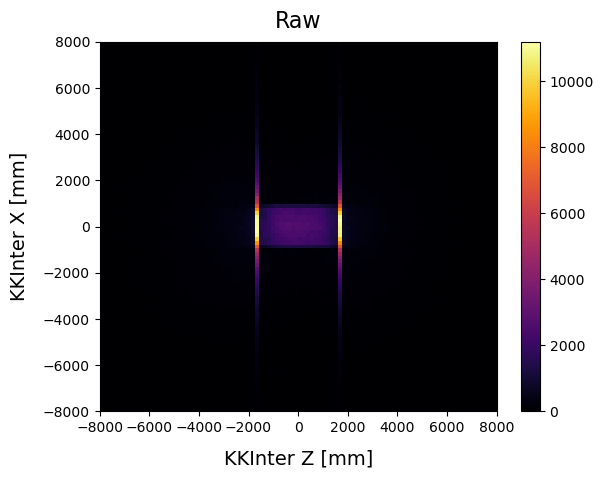


---> Written:
	 ../Images/MDC2020ae/TrackCuts//h2_ZX_raw.png


<Figure size 640x480 with 0 Axes>

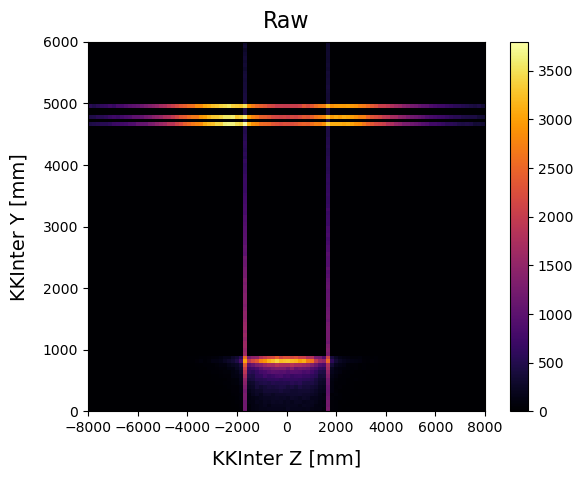


---> Written:
	 ../Images/MDC2020ae/TrackCuts/h2_ZY_raw.png


<Figure size 640x480 with 0 Axes>

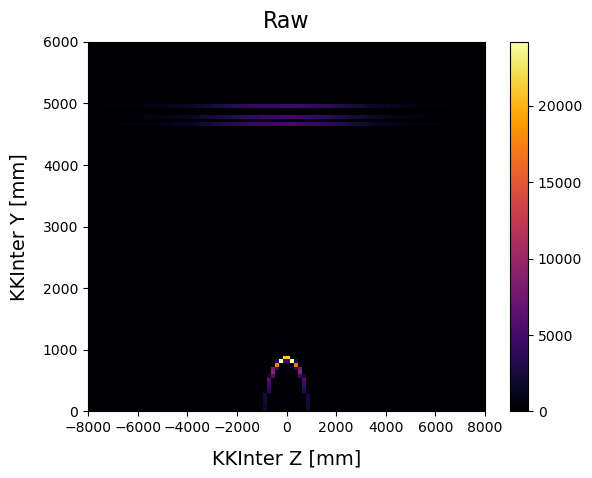


---> Written:
	 ../Images/MDC2020ae/TrackCuts//h2_XY_raw.png


<Figure size 640x480 with 0 Axes>

In [9]:
'''
Just raw data
'''

ut.PrintNEvents(data_, 1)

Plot2D(x=ak.flatten(data_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fZ"], axis=None)#[:1000]
         , y=ak.flatten(data_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fX"], axis=None)#[:1000]
         , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=-8000, ymax=8000
         # , xbox_= [-crvDS_len/2, crvDS_len/2], ybox_ =  [-crvDS_wid/2, crvDS_wid/2]
         , title="Raw", xlabel="KKInter Z [mm]", ylabel="KKInter X [mm]"
         , fout=f"../Images/{recon}/TrackCuts//h2_ZX_raw.png")

Plot2D(x=ak.flatten(data_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fZ"], axis=None)#[:1000]
         , y=ak.flatten(data_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fY"], axis=None)#[:1000]
         , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=0, ymax=6000
         # , xbox_= [-crvDS_len/2, crvDS_len/2], ybox_ =  [-crvDS_wid/2, crvDS_wid/2]
         , title="Raw", xlabel="KKInter Z [mm]", ylabel="KKInter Y [mm]"
         , fout=f"../Images/{recon}/TrackCuts/h2_ZY_raw.png")

Plot2D(x=ak.flatten(data_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fX"], axis=None)#[:1000]
         , y=ak.flatten(data_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fY"], axis=None)#[:1000]
         , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=0, ymax=6000
         # , xbox_= [-crvDS_len/2, crvDS_len/2], ybox_ =  [-crvDS_wid/2, crvDS_wid/2]
         , title="Raw", xlabel="KKInter Z [mm]", ylabel="KKInter Y [mm]"
         , fout=f"../Images/{recon}/TrackCuts//h2_XY_raw.png")

In [10]:
# Original track cuts function
def OriginalApplyTrackerCuts(arrays_, fail=False, quiet=False):
    
    if not quiet: print(f"\n---> Applying tracker cuts") 
    
    arrays_["trkfit_KLCRV1"] = ( 
        (arrays_["trkfit"]["klfit"]["sid"] == 200) 
        & (arrays_["trkfit"]["klfit"]["sindex"] == 1) )

    arrays_["trk_bestFit"] = ( 
        (arrays_["trk"]["kl.ndof"] >= 10)
        & (arrays_["trk"]["kl.fitcon"] > 0.1)
        & ((arrays_["trk"]["kl.nactive"]/arrays_["trk"]["kl.nhits"]) > 0.99)
        & (arrays_["trk"]["kl.nplanes"] >= 4)
        & ((arrays_["trk"]["kl.nnullambig"]/arrays_["trk"]["kl.nhits"]) < 0.2) )
    
    arrays_["trkfit_bestFit"] = ( 
        (arrays_["trkfit"]["klkl"]["z0err"] < 1) 
        & (arrays_["trkfit"]["klkl"]["d0err"] < 1) 
        & (arrays_["trkfit"]["klkl"]["thetaerr"] < 0.004)
        & (arrays_["trkfit"]["klkl"]["phi0err"] < 0.001) )

    # Apply cuts on the track and track fit level
    if not fail: 
        arrays_["trkfit"] = arrays_["trkfit"][(arrays_["trkfit_bestFit"] & arrays_["trkfit_KLCRV1"])]
        arrays_["trk"] = arrays_["trk"][arrays_["trk_bestFit"]]
    else: 
        arrays_["trkfit"] = arrays_["trkfit"][~(arrays_["trkfit_bestFit"] & arrays_["trkfit_KLCRV1"])]
        arrays_["trk"] = arrays_["trk"][~arrays_["trk_bestFit"]]

    # These cuts are applied to trk and trkfit, events that fail will now have no track cut informatio.
    # Mark events which still have tracks or track fits after cuts

    arrays_["goodTrk"] = ak.any(arrays_["trk"]["kl.status"], axis=1, keepdims=False) > 0 
    arrays_["goodTrkFit"] = (
        (ak.count(arrays_["trkfit"]["klfit"]["sid"], axis=-1, keepdims=False) > 0) 
        & (ak.count(arrays_["trkfit"]["klkl"]["z0err"], axis=-1, keepdims=False) > 0) )
    
    # Reset to event level
    arrays_["goodTrkFit"] = ak.any(arrays_["goodTrkFit"], axis=-1, keepdims=False) == True 

    # Mark total track cuts
    arrays_["pass_track_cuts"] = (arrays_["goodTrk"] & arrays_["goodTrkFit"])

    # Return events passing/failing track fits
    if not fail:  
        return arrays_[arrays_["pass_track_cuts"]]
    else:
        return arrays_[~arrays_["pass_track_cuts"]]

In [86]:
# # Corrected track cuts function
# '''
# Original does not seem to work properly, it still returns events with no track information after cuts.
# Also, we do NOT want to apply and event level cut based on the track fit objects.
# Take care with the local fit parameters. What we return depends on pass/fail.

# If we "fail" 

# '''

# def ApplyTrackerCuts(arrays_, fail=False, quiet=False):
    
#     if not quiet: print(f"\n---> Applying tracker cuts") 

#     # Mark cuts on the track and track fit level
#     arrays_["trkfit_KLCRV1"] = ( 
#         (arrays_["trkfit"]["klfit"]["sid"] == 200) 
#         & (arrays_["trkfit"]["klfit"]["sindex"] == 1) )

#     arrays_["trk_bestFit"] = ( 
#         (arrays_["trk"]["kl.ndof"] >= 10)
#         & (arrays_["trk"]["kl.fitcon"] > 0.1)
#         & ((arrays_["trk"]["kl.nactive"]/arrays_["trk"]["kl.nhits"]) > 0.99)
#         & (arrays_["trk"]["kl.nplanes"] >= 4)
#         & ((arrays_["trk"]["kl.nnullambig"]/arrays_["trk"]["kl.nhits"]) < 0.2) )
    
#     arrays_["trkfit_bestFit"] = ( 
#         (arrays_["trkfit"]["klkl"]["z0err"] < 1) 
#         & (arrays_["trkfit"]["klkl"]["d0err"] < 1) 
#         & (arrays_["trkfit"]["klkl"]["thetaerr"] < 0.004)
#         & (arrays_["trkfit"]["klkl"]["phi0err"] < 0.001) )

#     if not fail: 
#         # Create masks
#         arrays_["trkfit"] = arrays_["trkfit"][(arrays_["trkfit_bestFit"] & arrays_["trkfit_KLCRV1"])]
#         arrays_["trk"] = arrays_["trk"][arrays_["trk_bestFit"]]
#         # Check for a track in the event after cuts.
#         passTrk = ak.any(arrays_["trk"]["kl.status"], axis=1, keepdims=False) > 0 
#         # Check for a track fit in the event after cuts
#         passTrkFit = (
#             (ak.count(arrays_["trkfit"]["klfit"]["sid"], axis=-1, keepdims=False) > 0) 
#             & (ak.count(arrays_["trkfit"]["klkl"]["z0err"], axis=-1, keepdims=False) > 0) )
#         # Reset to event level
#         passTrkFit = ak.any(passTrkFit, axis=-1, keepdims=False) == True 
#         # Mark total track cuts
#         arrays_["pass_track_cuts"] = (passTrk & passTrkFit)
#         # Return events
#         return arrays_[arrays_["pass_track_cuts"]]
#     else: 
#         # Create masks
#         arrays_["trkfit"] = arrays_["trkfit"][~(arrays_["trkfit_bestFit"] & arrays_["trkfit_KLCRV1"])]
#         arrays_["trk"] = arrays_["trk"][~arrays_["trk_bestFit"]]
#         # Check for a track in the event after cuts.
#         arrays_["fail_trk"] = ak.any(arrays_["trk"]["kl.status"], axis=1, keepdims=False) > 0 
#        # Check for a track fit in the event after cuts
#         arrays_["fail_trkfit"] = (
#             (ak.count(arrays_["trkfit"]["klfit"]["sid"], axis=-1, keepdims=False) > 0) 
#             & (ak.count(arrays_["trkfit"]["klkl"]["z0err"], axis=-1, keepdims=False) > 0) )

#     # Check for a track in the event after cuts.
#     arrays_["good_track"] = ak.any(arrays_["trk"]["kl.status"], axis=1, keepdims=False) > 0 

#     # Return events that sill contain tracks after passing/failing cuts.
#     return arrays_[arrays_["has_track"]]

# Corrected track cuts function
'''

Take care with the local fit parameters. What we return depends on pass/fail.

If we "fail" 

'''

def ApplyTrackerCuts(arrays_, fail=False, quiet=False):
    
    if not quiet: print(f"\n---> Applying tracker cuts") 

    # Mark cuts on the track and track fit level
    arrays_["trkfit_KLCRV1"] = ( 
        (arrays_["trkfit"]["klfit"]["sid"] == 200) 
        & (arrays_["trkfit"]["klfit"]["sindex"] == 1) )

    arrays_["trk_bestFit"] = ( 
        (arrays_["trk"]["kl.ndof"] >= 10)
        & (arrays_["trk"]["kl.fitcon"] > 0.1)
        & ((arrays_["trk"]["kl.nactive"]/arrays_["trk"]["kl.nhits"]) > 0.99)
        & (arrays_["trk"]["kl.nplanes"] >= 4)
        & ((arrays_["trk"]["kl.nnullambig"]/arrays_["trk"]["kl.nhits"]) < 0.2) )
    
    arrays_["trkfit_bestFit"] = ( 
        (arrays_["trkfit"]["klkl"]["z0err"] < 1) 
        & (arrays_["trkfit"]["klkl"]["d0err"] < 1) 
        & (arrays_["trkfit"]["klkl"]["thetaerr"] < 0.004)
        & (arrays_["trkfit"]["klkl"]["phi0err"] < 0.001) )

    if not fail: 
        # Create masks
        arrays_["trkfit"] = arrays_["trkfit"][(arrays_["trkfit_bestFit"] & arrays_["trkfit_KLCRV1"])]
        arrays_["trk"] = arrays_["trk"][arrays_["trk_bestFit"]]
    else: 
        # Create masks
        arrays_["trkfit"] = arrays_["trkfit"][~(arrays_["trkfit_bestFit"] & arrays_["trkfit_KLCRV1"])]
        arrays_["trk"] = arrays_["trk"][~arrays_["trk_bestFit"]]

    # Check for a track in the event after cuts.
    trkCut = ak.any(arrays_["trk"]["kl.status"], axis=1, keepdims=False) > 0 
    # Check for a track fit in the event after cuts
    trkFitCut = (
        (ak.count(arrays_["trkfit"]["klfit"]["sid"], axis=-1, keepdims=False) > 0) 
        & (ak.count(arrays_["trkfit"]["klkl"]["z0err"], axis=-1, keepdims=False) > 0) )
    
    # Reset to event level
    trkFitCut = ak.any(trkFitCut, axis=-1, keepdims=False) == True 
    
    # Return arrays

    # Both do the same thing, but mark them pass/fail for bookkeeping.
    if not fail: 
        arrays_["pass_track_cuts"] = (trkCut & trkFitCut)
        return arrays_[arrays_["pass_track_cuts"]]
    else: 
        arrays_["fail_track_cuts"] = (trkCut & trkFitCut)
        return arrays_[arrays_["fail_track_cuts"]]

In [67]:
# track_cuts_old_ = ak.copy(data_)
# track_cuts_old_ = OriginalApplyTrackerCuts(track_cuts_old_, fail=True)

# track_cuts_fail_old_ = ak.copy(data_)
# track_cuts_faulold_ = OriginalApplyTrackerCuts(track_cuts_old_, fail=True)

track_cuts_test_ = ak.copy(data_)
track_cuts_test_ = ApplyTrackerCuts(track_cuts_test_, fail=False)

track_cuts_fail_test_ = ak.copy(data_)
track_cuts_fail_test_ = ApplyTrackerCuts(track_cuts_fail_test_, fail=True)

ut.PrintNEvents(track_cuts_test_, 1)
ut.PrintNEvents(track_cuts_fail_test_, 1)


---> Applying tracker cuts

---> Applying tracker cuts
-------------------------------------------------------------------------------------
***** evt *****
evtinfo.run: 1205
evtinfo.subrun: 6
evtinfo.event: 229
***** crv *****
crvcoincs.sectorType: []
crvcoincs.nLayers []
crvcoincs.angle: []
crvcoincs.pos.fCoordinates: ([], [], [])
crvcoincs.timeStart: []
crvcoincs.time: []
crvcoincs.PEs: []
crvcoincs.PEsPerLayer[4]: []
crvcoincs.nHits: []
crvcoincsmc.pdgId: []
crvcoincsmc.valid: []
crvcoincsmc.primaryE: []
***** trk *****
kl.status: [1]
kl.nactive: [20]
kl.nhits: [20]
kl.nplanes: [8]
kl.nnullambig: [2]
kl.ndof: [35]
kl.kl.fitcon: [0.196]
***** trkfit *****
klfit: [[{mom: {fCoordinates: {...}}, pos: {...}, time: 4.18e+04, momerr: ..., ...}]]
klfit.sid: [[200]]
klfit.sindex: [[1]]
klkl: [[{d0: -539, phi0: -1.62, z0: 521, theta: 2.28, mom: 2e+03, t0: 4.18e+04, ...}]]
klkl.z0err: [[0.238]]
klkl.d0err: [[0.113]]
klkl.thetaerr: [[0.000306]]
klkl.phi0err: [[0.000425]]
---------------------

In [13]:
# # Filters
# filters_ = { 
#     0 : "singles"
#     , 1 : "track_cuts"
#     , 2 : "singles_track_cuts"
#     # , 3 : "pass_singles_fail_track_cuts" # this is where the supposed improvement comes in. 
#     , 4 : "fail_singles_pass_track_cuts"
#     , 5 : "fail_singles_fail_track_cuts"
# }


---> Applying tracker cuts
-------------------------------------------------------------------------------------
***** evt *****
evtinfo.run: 1205
evtinfo.subrun: 6
evtinfo.event: 229
***** crv *****
crvcoincs.sectorType: []
crvcoincs.nLayers []
crvcoincs.angle: []
crvcoincs.pos.fCoordinates: ([], [], [])
crvcoincs.timeStart: []
crvcoincs.time: []
crvcoincs.PEs: []
crvcoincs.PEsPerLayer[4]: []
crvcoincs.nHits: []
crvcoincsmc.pdgId: []
crvcoincsmc.valid: []
crvcoincsmc.primaryE: []
***** trk *****
kl.status: [1]
kl.nactive: [20]
kl.nhits: [20]
kl.nplanes: [8]
kl.nnullambig: [2]
kl.ndof: [35]
kl.kl.fitcon: [0.196]
***** trkfit *****
klfit: [[{mom: {fCoordinates: {...}}, pos: {...}, time: 4.18e+04, momerr: ..., ...}]]
klfit.sid: [[200]]
klfit.sindex: [[1]]
klkl: [[{d0: -539, phi0: -1.62, z0: 521, theta: 2.28, mom: 2e+03, t0: 4.18e+04, ...}]]
klkl.z0err: [[0.238]]
klkl.d0err: [[0.113]]
klkl.thetaerr: [[0.000306]]
klkl.phi0err: [[0.000425]]
-------------------------------------------------

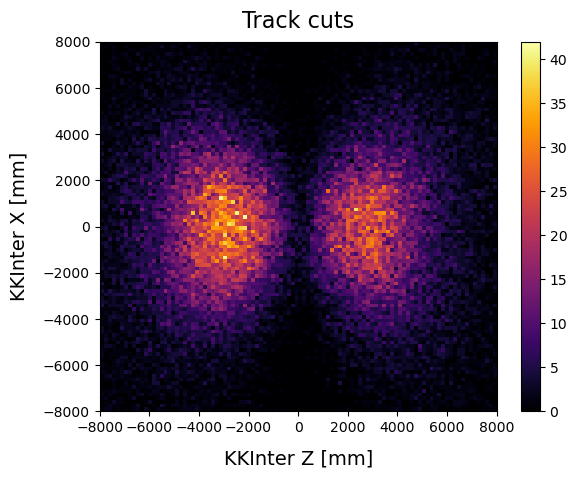


---> Written:
	 ../Images/MDC2020ae/TrackCuts/h2_ZX_track_cuts.png


<Figure size 640x480 with 0 Axes>

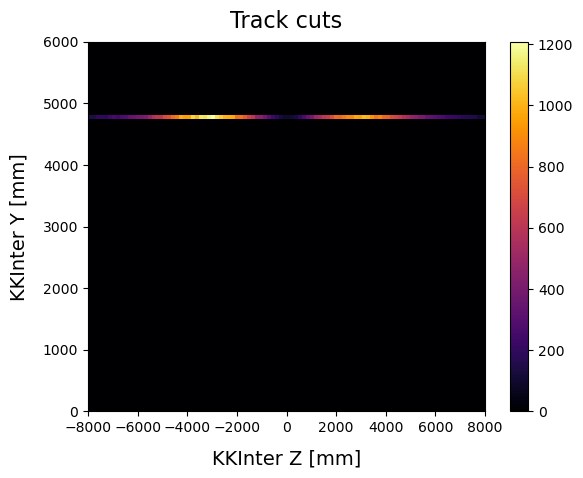


---> Written:
	 ../Images/MDC2020ae/TrackCuts//h2_ZY_track_cuts.png


<Figure size 640x480 with 0 Axes>

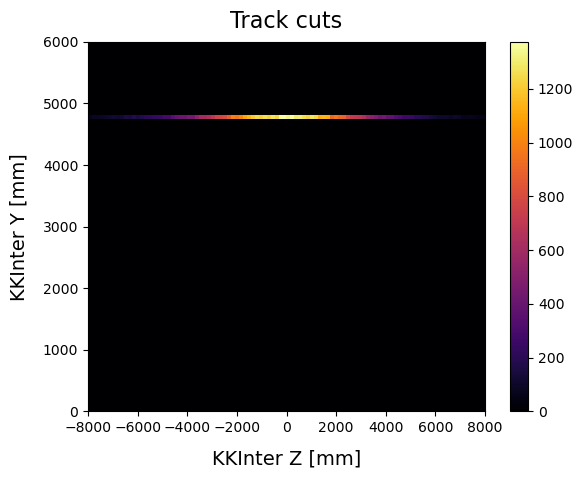


---> Written:
	 ../Images/MDC2020ae/TrackCuts//h2_XY_track_cuts.png


<Figure size 640x480 with 0 Axes>

In [68]:
'''
Track cuts only
'''

track_cuts_ = ak.copy(data_)
track_cuts_ = ApplyTrackerCuts(track_cuts_, fail=False)

ut.PrintNEvents(track_cuts_, 1)

Plot2D(x=ak.flatten(track_cuts_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fZ"], axis=None)#[:1000]
       , y=ak.flatten(track_cuts_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fX"], axis=None)#[:1000]
       , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=-8000, ymax=8000
       # , xbox_= [-crvDS_len/2, crvDS_len/2], ybox_ =  [-crvDS_wid/2, crvDS_wid/2]
       , title="Track cuts", xlabel="KKInter Z [mm]", ylabel="KKInter X [mm]"
       , fout=f"../Images/{recon}/TrackCuts/h2_ZX_track_cuts.png")

Plot2D(x=ak.flatten(track_cuts_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fZ"], axis=None)#[:1000]
       , y=ak.flatten(track_cuts_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fY"], axis=None)#[:1000]
       , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=0, ymax=6000
       # , xbox_= [-crvDS_len/2, crvDS_len/2], ybox_ =  [-crvDS_wid/2, crvDS_wid/2]
       , title="Track cuts", xlabel="KKInter Z [mm]", ylabel="KKInter Y [mm]"
       , fout=f"../Images/{recon}/TrackCuts//h2_ZY_track_cuts.png")

Plot2D(x=ak.flatten(track_cuts_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fX"], axis=None)#[:1000]
       , y=ak.flatten(track_cuts_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fY"], axis=None)#[:1000]
       , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=0, ymax=6000
       # , xbox_= [-crvDS_len/2, crvDS_len/2], ybox_ =  [-crvDS_wid/2, crvDS_wid/2]
       , title="Track cuts", xlabel="KKInter Z [mm]", ylabel="KKInter Y [mm]"
       , fout=f"../Images/{recon}/TrackCuts//h2_XY_track_cuts.png")


---> Applying tracker cuts
Total track fits = 1497826
Passing track fits = 59122
Failing track fits = 948687
total != passing + failing
-------------------------------------------------------------------------------------
***** evt *****
evtinfo.run: 1205
evtinfo.subrun: 6
evtinfo.event: 291
***** crv *****
crvcoincs.sectorType: []
crvcoincs.nLayers []
crvcoincs.angle: []
crvcoincs.pos.fCoordinates: ([], [], [])
crvcoincs.timeStart: []
crvcoincs.time: []
crvcoincs.PEs: []
crvcoincs.PEsPerLayer[4]: []
crvcoincs.nHits: []
crvcoincsmc.pdgId: []
crvcoincsmc.valid: []
crvcoincsmc.primaryE: []
***** trk *****
kl.status: [1]
kl.nactive: [21]
kl.nhits: [21]
kl.nplanes: [8]
kl.nnullambig: [6]
kl.ndof: [37]
kl.kl.fitcon: [0.437]
***** trkfit *****
klfit: [[{mom: {fCoordinates: {...}}, pos: {...}, time: 7.02e+04, ...}, ..., {...}]]
klfit.sid: [[0, 2, 4, 4, 4, 200, 200]]
klfit.sindex: [[0, 0, 0, 0, 0, 0, 2]]
klkl: [[{d0: 506, phi0: -2.25, z0: 1.29e+03, theta: 0.947, mom: 2e+03, ...}, ...]]
klkl.z

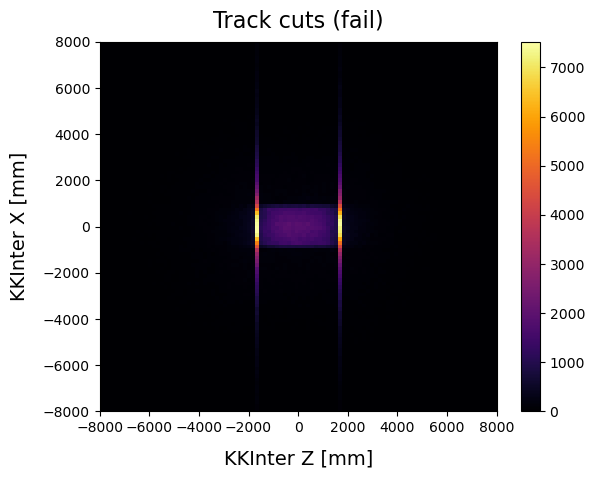


---> Written:
	 ../Images/MDC2020ae/TrackCuts/h2_ZX_track_cuts_fail.png


<Figure size 640x480 with 0 Axes>

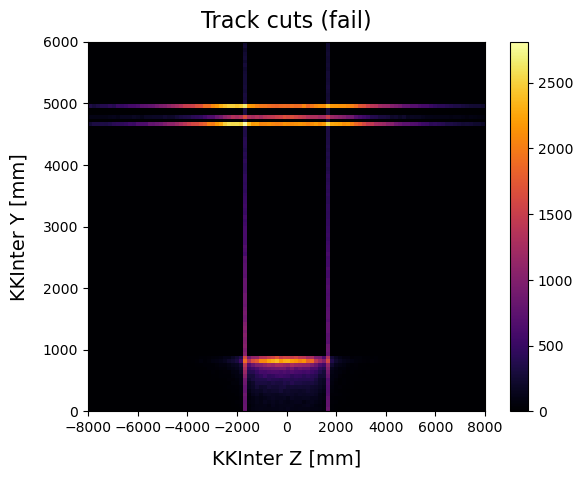


---> Written:
	 ../Images/MDC2020ae/TrackCuts//h2_ZY_track_cuts_fail.png


<Figure size 640x480 with 0 Axes>

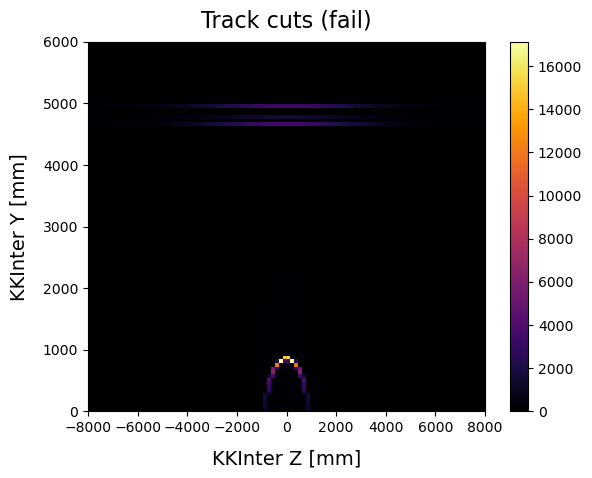


---> Written:
	 ../Images/MDC2020ae/TrackCuts//h2_XY_track_cuts_fail.png


<Figure size 640x480 with 0 Axes>

In [70]:
'''
Fail track cuts only
'''

track_cuts_fail_ = ak.copy(data_)
track_cuts_fail_ = ApplyTrackerCuts(track_cuts_fail_, fail=True)

# These don't actually add up. 
# Total < passing + failing 
# How does this happen, we must have some events in both camps. Can look at this. 

n_tot = len(ak.flatten(data_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fZ"], axis=None))
n_pass = len(ak.flatten(track_cuts_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fZ"], axis=None))
n_fail = len(ak.flatten(track_cuts_fail_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fZ"], axis=None))

print(f"Total track fits = {n_tot}")
print(f"Passing track fits = {n_pass}")
print(f"Failing track fits = {n_fail}")

if (n_tot == (n_pass + n_fail)): 
    print("total = passing + failing")
else:
    print("total != passing + failing")
    
ut.PrintNEvents(track_cuts_fail_, 1)

Plot2D(x=ak.flatten(track_cuts_fail_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fZ"], axis=None)#[:1000]
       , y=ak.flatten(track_cuts_fail_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fX"], axis=None)#[:1000]
       , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=-8000, ymax=8000
       # , xbox_= [-crvDS_len/2, crvDS_len/2], ybox_ =  [-crvDS_wid/2, crvDS_wid/2]
       , title="Track cuts (fail)", xlabel="KKInter Z [mm]", ylabel="KKInter X [mm]"
       , fout=f"../Images/{recon}/TrackCuts/h2_ZX_track_cuts_fail.png")

Plot2D(x=ak.flatten(track_cuts_fail_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fZ"], axis=None)#[:1000]
       , y=ak.flatten(track_cuts_fail_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fY"], axis=None)#[:1000]
       , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=0, ymax=6000
       # , xbox_= [-crvDS_len/2, crvDS_len/2], ybox_ =  [-crvDS_wid/2, crvDS_wid/2]
       , title="Track cuts (fail)", xlabel="KKInter Z [mm]", ylabel="KKInter Y [mm]"
       , fout=f"../Images/{recon}/TrackCuts//h2_ZY_track_cuts_fail.png")

Plot2D(x=ak.flatten(track_cuts_fail_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fX"], axis=None)#[:1000]
       , y=ak.flatten(track_cuts_fail_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fY"], axis=None)#[:1000]
       , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=0, ymax=6000
       # , xbox_= [-crvDS_len/2, crvDS_len/2], ybox_ =  [-crvDS_wid/2, crvDS_wid/2]
       , title="Track cuts (fail)", xlabel="KKInter Z [mm]", ylabel="KKInter Y [mm]"
       , fout=f"../Images/{recon}/TrackCuts//h2_XY_track_cuts_fail.png")

In [16]:
# Interesting event
# pr.PrintNEvents(data_[(raw_data_["evt"]["evtinfo.run"] == 1205) & (data_["evt"]["evtinfo.subrun"] == 6) & (data_["evt"]["evtinfo.event"] == 6837)])
# print(track_cuts_[(track_cuts_["evt"]["evtinfo.run"] == 1205) & (track_cuts_["evt"]["evtinfo.subrun"] == 6) & (track_cuts_["evt"]["evtinfo.event"] == 6837)])
# pr.PrintNEvents(track_cuts_[(track_cuts_["evt"]["evtinfo.run"] == 1205) & (track_cuts_["evt"]["evtinfo.subrun"] == 6) & (track_cuts_["evt"]["evtinfo.event"] == 6837)])
# So it simply does not exist


---> Applying tracker cuts
-------------------------------------------------------------------------------------
***** evt *****
evtinfo.run: 1205
evtinfo.subrun: 6
evtinfo.event: 5143
***** crv *****
crvcoincs.sectorType: [1]
crvcoincs.nLayers [3]
crvcoincs.angle: [0.33]
crvcoincs.pos.fCoordinates: ([1.47e+03], [4.75e+03], [1.09e+03])
crvcoincs.timeStart: [5.43e+04]
crvcoincs.time: [5.43e+04]
crvcoincs.PEs: [340]
crvcoincs.PEsPerLayer[4]: [[167, 136, 36.5, 0]]
crvcoincs.nHits: [12]
crvcoincsmc.pdgId: [-13]
crvcoincsmc.valid: [True]
crvcoincsmc.primaryE: [1.08e+04]
***** trk *****
kl.status: [1]
kl.nactive: [26]
kl.nhits: [26]
kl.nplanes: [5]
kl.nnullambig: [0]
kl.ndof: [47]
kl.kl.fitcon: [0.923]
***** trkfit *****
klfit: [[{mom: {fCoordinates: {...}}, pos: {...}, time: 5.43e+04, momerr: ..., ...}]]
klfit.sid: [[200]]
klfit.sindex: [[1]]
klkl: [[{d0: -513, phi0: -1.87, z0: -1.13e+03, theta: 2.01, mom: 2e+03, ...}]]
klkl.z0err: [[0.179]]
klkl.d0err: [[0.139]]
klkl.thetaerr: [[0.000281]

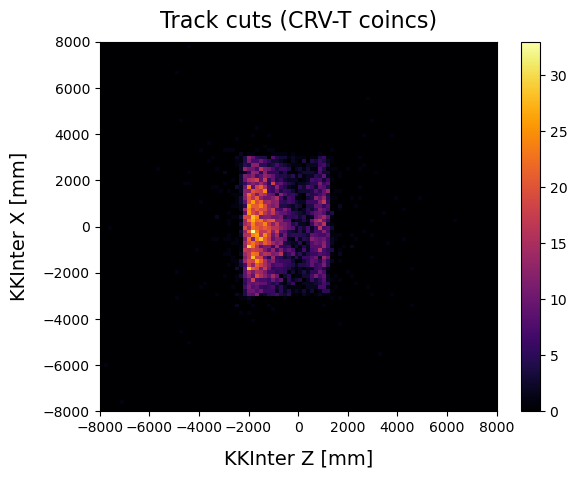


---> Written:
	 ../Images/MDC2020ae/TrackCuts/h2_ZX_track_cuts_CRVT.png


<Figure size 640x480 with 0 Axes>

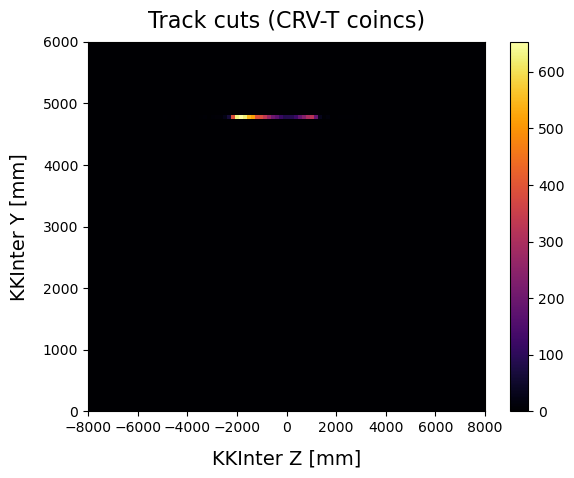


---> Written:
	 ../Images/MDC2020ae/TrackCuts/h2_ZY_track_cuts_CRVT.png


<Figure size 640x480 with 0 Axes>

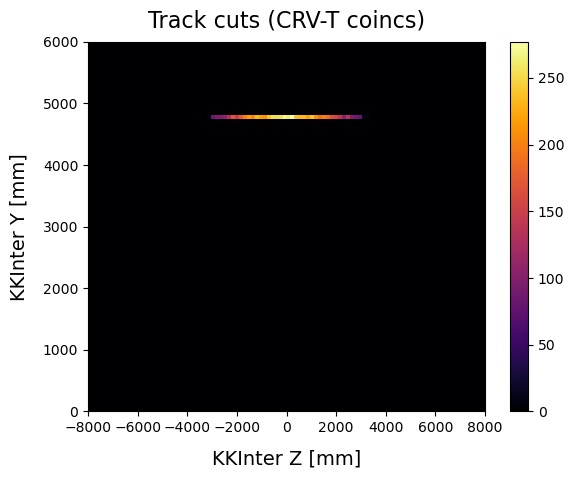


---> Written:
	 ../Images/MDC2020ae/TrackCuts/h2_XY_track_cuts_CRVT.png


<Figure size 640x480 with 0 Axes>

In [71]:
'''
Track cuts (CRV-T coinc)
'''

track_cuts_CRVT_ = ak.copy(data_)
track_cuts_CRVT_ = ApplyTrackerCuts(track_cuts_CRVT_)
track_cuts_CRVT_["crv"] = track_cuts_CRVT_["crv"][track_cuts_CRVT_["crv"]["crvcoincs.sectorType"] == 1]

# Now remove events with no coincidence
# We actually do not do this directly in main code, although I do trigger which should do it?
goodCRV =  ak.any(track_cuts_CRVT_["crv"]["crvcoincs.nHits"], axis=1, keepdims=False) > 0
track_cuts_CRVT_ = track_cuts_CRVT_[goodCRV]

ut.PrintNEvents(track_cuts_CRVT_, 1)

Plot2D(x=ak.flatten(track_cuts_CRVT_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fZ"], axis=None)#[:1000]
       , y=ak.flatten(track_cuts_CRVT_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fX"], axis=None)#[:1000]
       , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=-8000, ymax=8000
       # , xbox_= [-crvDS_len/2, crvDS_len/2], ybox_ =  [-crvDS_wid/2, crvDS_wid/2]
       , title="Track cuts (CRV-T coincs)", xlabel="KKInter Z [mm]", ylabel="KKInter X [mm]"
       , fout=f"../Images/{recon}/TrackCuts/h2_ZX_track_cuts_CRVT.png")

Plot2D(x=ak.flatten(track_cuts_CRVT_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fZ"], axis=None)#[:1000]
       , y=ak.flatten(track_cuts_CRVT_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fY"], axis=None)#[:1000]
       , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=0, ymax=6000
       # , xbox_= [-crvDS_len/2, crvDS_len/2], ybox_ =  [-crvDS_wid/2, crvDS_wid/2]
       , title="Track cuts (CRV-T coincs)", xlabel="KKInter Z [mm]", ylabel="KKInter Y [mm]"
       , fout=f"../Images/{recon}/TrackCuts/h2_ZY_track_cuts_CRVT.png")

Plot2D(x=ak.flatten(track_cuts_CRVT_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fX"], axis=None)#[:1000]
       , y=ak.flatten(track_cuts_CRVT_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fY"], axis=None)#[:1000]
       , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=0, ymax=6000
       # , xbox_= [-crvDS_len/2, crvDS_len/2], ybox_ =  [-crvDS_wid/2, crvDS_wid/2]
       , title="Track cuts (CRV-T coincs)", xlabel="KKInter Z [mm]", ylabel="KKInter Y [mm]"
       , fout=f"../Images/{recon}/TrackCuts/h2_XY_track_cuts_CRVT.png")


---> Applying tracker cuts
-------------------------------------------------------------------------------------
***** evt *****
evtinfo.run: 1205
evtinfo.subrun: 6
evtinfo.event: 3776
***** crv *****
crvcoincs.sectorType: [1]
crvcoincs.nLayers [4]
crvcoincs.angle: [-0.705]
crvcoincs.pos.fCoordinates: ([354], [4.78e+03], [-1.9e+03])
crvcoincs.timeStart: [4.44e+04]
crvcoincs.time: [4.44e+04]
crvcoincs.PEs: [448]
crvcoincs.PEsPerLayer[4]: [[72.1, 138, 102, 136]]
crvcoincs.nHits: [16]
crvcoincsmc.pdgId: [13]
crvcoincsmc.valid: [True]
crvcoincsmc.primaryE: [5.7e+03]
***** trk *****
kl.status: [1]
kl.nactive: [19]
kl.nhits: [19]
kl.nplanes: [4]
kl.nnullambig: [4]
kl.ndof: [33]
kl.kl.fitcon: [0.632]
***** trkfit *****
klfit: [[{mom: {fCoordinates: {...}}, pos: {...}, time: 4.44e+04, ...}, ..., {...}]]
klfit.sid: [[0, 2, 4, 4, 4, 200, 200]]
klfit.sindex: [[0, 0, 0, 0, 0, 0, 2]]
klkl: [[{d0: 531, phi0: -1.59, z0: -252, theta: 1.24, mom: 2e+03, t0: ..., ...}, ...]]
klkl.z0err: [[0.114, 0.13, 0

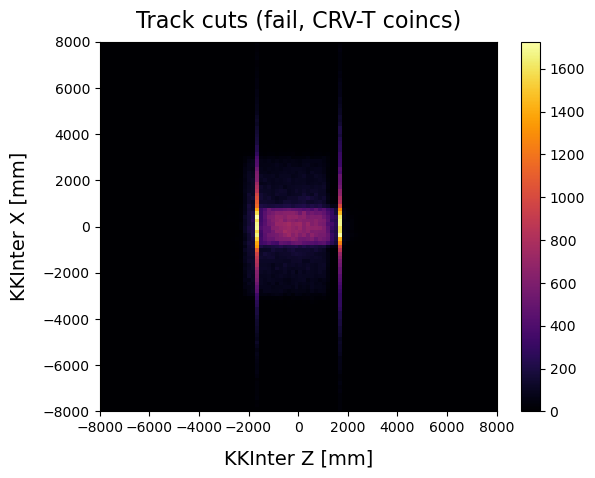


---> Written:
	 ../Images/MDC2020ae/TrackCuts/h2_ZX_track_cuts_fail_CRVT.png


<Figure size 640x480 with 0 Axes>

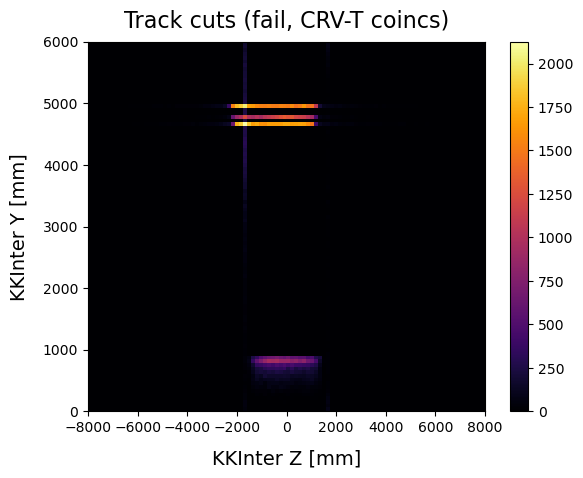


---> Written:
	 ../Images/MDC2020ae/TrackCuts/h2_ZY_track_cuts_fail_CRVT.png


<Figure size 640x480 with 0 Axes>

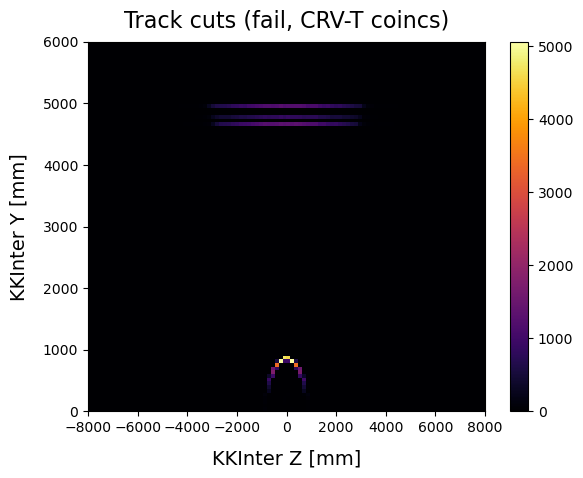


---> Written:
	 ../Images/MDC2020ae/TrackCuts/h2_XY_track_cuts_fail_CRVT.png


<Figure size 640x480 with 0 Axes>

In [72]:
'''
Track cuts fail (CRV-T coinc)

Essentially meaningless, the CRV cuts are independent of the tracker cuts.
'''

track_cuts_fail_CRVT_ = ak.copy(data_)
track_cuts_fail_CRVT_ = ApplyTrackerCuts(track_cuts_fail_CRVT_, fail=True)
track_cuts_fail_CRVT_["crv"] = track_cuts_fail_CRVT_["crv"][track_cuts_fail_CRVT_["crv"]["crvcoincs.sectorType"] == 1]

# Now remove events with no coincidence
# We actually do not do this directly in main code, although I do trigger which should do it?
goodCRV =  ak.any(track_cuts_fail_CRVT_["crv"]["crvcoincs.nHits"], axis=1, keepdims=False) > 0
track_cuts_fail_CRVT_ = track_cuts_fail_CRVT_[goodCRV]

ut.PrintNEvents(track_cuts_fail_CRVT_, 1)

Plot2D(x=ak.flatten(track_cuts_fail_CRVT_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fZ"], axis=None)#[:1000]
       , y=ak.flatten(track_cuts_fail_CRVT_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fX"], axis=None)#[:1000]
       , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=-8000, ymax=8000
       # , xbox_= [-crvDS_len/2, crvDS_len/2], ybox_ =  [-crvDS_wid/2, crvDS_wid/2]
       , title="Track cuts (fail, CRV-T coincs)", xlabel="KKInter Z [mm]", ylabel="KKInter X [mm]"
       , fout=f"../Images/{recon}/TrackCuts/h2_ZX_track_cuts_fail_CRVT.png")

Plot2D(x=ak.flatten(track_cuts_fail_CRVT_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fZ"], axis=None)#[:1000]
       , y=ak.flatten(track_cuts_fail_CRVT_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fY"], axis=None)#[:1000]
       , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=0, ymax=6000
       # , xbox_= [-crvDS_len/2, crvDS_len/2], ybox_ =  [-crvDS_wid/2, crvDS_wid/2]
       , title="Track cuts (fail, CRV-T coincs)", xlabel="KKInter Z [mm]", ylabel="KKInter Y [mm]"
       , fout=f"../Images/{recon}/TrackCuts/h2_ZY_track_cuts_fail_CRVT.png")

Plot2D(x=ak.flatten(track_cuts_fail_CRVT_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fX"], axis=None)#[:1000]
       , y=ak.flatten(track_cuts_fail_CRVT_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fY"], axis=None)#[:1000]
       , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=0, ymax=6000
       # , xbox_= [-crvDS_len/2, crvDS_len/2], ybox_ =  [-crvDS_wid/2, crvDS_wid/2]
       , title="Track cuts (fail, CRV-T coincs)", xlabel="KKInter Z [mm]", ylabel="KKInter Y [mm]"
       , fout=f"../Images/{recon}/TrackCuts/h2_XY_track_cuts_fail_CRVT.png")

In [19]:
pr.PrintNEvents(data_[(data_["evt"]["evtinfo.run"] == 1205) & (data_["evt"]["evtinfo.subrun"] == 6) & (data_["evt"]["evtinfo.event"] == 3776)])

-------------------------------------------------------------------------------------
***** evt *****
evtinfo.run: 1205
evtinfo.subrun: 6
evtinfo.eventid: 3776
***** crv *****
crvcoincs.sectorType: [1]
crvcoincs.nLayers [4]
crvcoincs.angle: [-0.705]
crvcoincs.pos.fCoordinates: ([354], [4.78e+03], [-1.9e+03])
crvcoincs.timeStart: [4.44e+04]
crvcoincs.time: [4.44e+04]
crvcoincs.PEs: [448]
crvcoincs.PEsPerLayer[4]: [[72.1, 138, 102, 136]]
crvcoincs.nHits: [16]
crvcoincsmc.pdgId: [13]
crvcoincsmc.valid: [True]
crvcoincsmc.primaryE: [5.7e+03]
***** trk *****
kl.status: [1]
kl.nactive: [19]
kl.nhits: [19]
kl.nplanes: [4]
kl.nnullambig: [4]
kl.ndof: [33]
kl.kl.fitcon: [0.632]
***** trkfit *****
klfit: [[{mom: {fCoordinates: {...}}, pos: {...}, time: 4.44e+04, ...}, ..., {...}]]
klfit.sid: [[0, 2, 4, 4, 4, 200, 200, 200]]
klfit.sindex: [[0, 0, 0, 0, 0, 0, 1, 2]]
klfit.time: [[4.44e+04, 4.45e+04, 4.44e+04, 4.44e+04, ..., 4.44e+04, 4.44e+04, 4.44e+04]]
klkl: [[{d0: 531, phi0: -1.59, z0: -252, th

In [20]:
'''
Trigger function
'''

def Trigger(data_, fail=False, quiet=False): 

    if not quiet: print(f"\n---> Triggering")
        
    # Enforce trigger condititon 
    triggerCondition = (
        ak.any((data_["crv"]["crvcoincs.sectorType"] == 2), axis=1) &
        ak.any((data_["crv"]["crvcoincs.sectorType"] == 3), axis=1)
    )

    data_["pass_trigger"] = triggerCondition
    
    if not quiet: print("Done!")

    if not fail: 
        return data_[data_["pass_trigger"]]
    else:
        return data_[~data_["pass_trigger"]]


---> Triggering
Done!
-------------------------------------------------------------------------------------
***** evt *****
evtinfo.run: 1205
evtinfo.subrun: 6
evtinfo.event: 6837
***** crv *****
crvcoincs.sectorType: [1, 2, 3]
crvcoincs.nLayers [4, 4, 2]
crvcoincs.angle: [-0.345, -1.99e-12, 0.32]
crvcoincs.pos.fCoordinates: ([472, 78.5, 642], [4.77e+03, 4.62e+03, 4.95e+03], [-1.3e+03, -437, -1.32e+03])
crvcoincs.timeStart: [6.7e+04, 6.7e+04, 6.7e+04]
crvcoincs.time: [6.7e+04, 6.7e+04, 6.7e+04]
crvcoincs.PEs: [516, 462, 256]
crvcoincs.PEsPerLayer[4]: [[144, 111, 141, 121], [127, 105, 106, 125], [0, 0, 149, 106]]
crvcoincs.nHits: [16, 8, 8]
crvcoincsmc.pdgId: [-13, -13, -13]
crvcoincsmc.valid: [True, True, True]
crvcoincsmc.primaryE: [3.7e+04, 3.7e+04, 3.7e+04]
***** trk *****
kl.status: [1]
kl.nactive: [15]
kl.nhits: [15]
kl.nplanes: [2]
kl.nnullambig: [3]
kl.ndof: [25]
kl.kl.fitcon: [0.87]
***** trkfit *****
klfit: [[{mom: {fCoordinates: {...}}, pos: {...}, time: 6.7e+04, ...}, ..., 

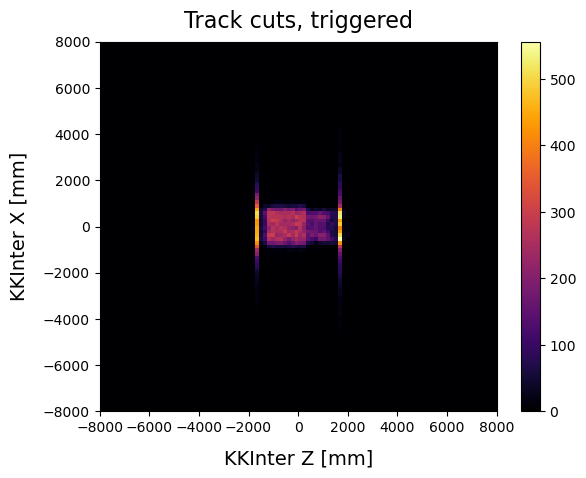


---> Written:
	 ../Images/MDC2020ae/TrackCuts/h2_ZX_triggered.png


<Figure size 640x480 with 0 Axes>

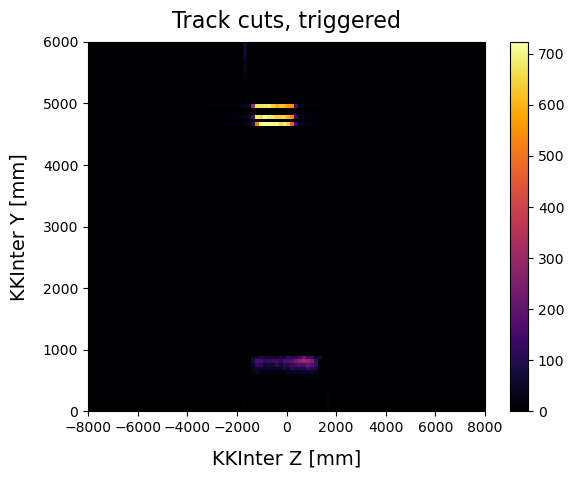


---> Written:
	 ../Images/MDC2020ae/TrackCuts/h2_ZY_triggered.png


<Figure size 640x480 with 0 Axes>

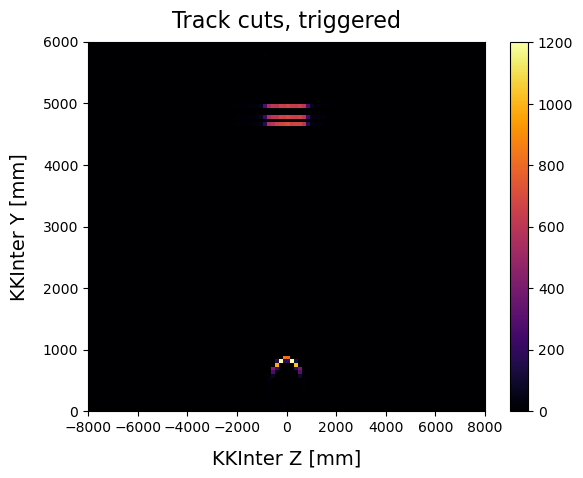


---> Written:
	 ../Images/MDC2020ae/TrackCuts/h2_XY_triggered.png


<Figure size 640x480 with 0 Axes>

In [21]:
'''
Triggered
'''

# Better to start from scratch each time
triggered_ = ak.copy(data_)
triggered_ = Trigger(triggered_)

ut.PrintNEvents(triggered_, 1)

Plot2D(x=ak.flatten(triggered_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fZ"], axis=None)#[:1000]
       , y=ak.flatten(triggered_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fX"], axis=None)#[:1000]
       , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=-8000, ymax=8000
       # , xbox_= [-crvDS_len/2, crvDS_len/2], ybox_ =  [-crvDS_wid/2, crvDS_wid/2]
       , title="Triggered", xlabel="KKInter Z [mm]", ylabel="KKInter X [mm]"
       , fout=f"../Images/{recon}/TrackCuts/h2_ZX_triggered.png")

Plot2D(x=ak.flatten(triggered_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fZ"], axis=None)#[:1000]
       , y=ak.flatten(triggered_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fY"], axis=None)#[:1000]
       , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=0, ymax=6000
       # , xbox_= [-crvDS_len/2, crvDS_len/2], ybox_ =  [-crvDS_wid/2, crvDS_wid/2]
       , title="Triggered", xlabel="KKInter Z [mm]", ylabel="KKInter Y [mm]"
       , fout=f"../Images/{recon}/TrackCuts/h2_ZY_triggered.png")

Plot2D(x=ak.flatten(triggered_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fX"], axis=None)#[:1000]
       , y=ak.flatten(triggered_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fY"], axis=None)#[:1000]
       , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=0, ymax=6000
       # , xbox_= [-crvDS_len/2, crvDS_len/2], ybox_ =  [-crvDS_wid/2, crvDS_wid/2]
       , title="Triggered", xlabel="KKInter Z [mm]", ylabel="KKInter Y [mm]"
       , fout=f"../Images/{recon}/TrackCuts/h2_XY_triggered.png")

In [22]:
'''
Singles cut function
'''

#  Events with ONE coincidence in sectors 2 & 3 
#  AND no more than one coincidence in sector 1 (with default coin conditions) 
def OriginalFilterSingles(arrays_, fail=False, quiet=False):
    
    if not quiet: print(f"\n---> Filtering singles") 

    sector1Condition = arrays_["crv"]["crvcoincs.sectorType"] == 1
    sector2Condition = arrays_["crv"]["crvcoincs.sectorType"] == 2
    sector3Condition = arrays_["crv"]["crvcoincs.sectorType"] == 3

    oneOrZeroCoincInMeasurementSector = ak.count(arrays_["crv"]["crvcoincs.sectorType"][sector1Condition], axis=1) < 2
    oneCoincInSector2Condition = ak.count(arrays_["crv"]["crvcoincs.sectorType"][sector2Condition], axis=1) == 1
    oneCoincInSector3Condition = ak.count(arrays_["crv"]["crvcoincs.sectorType"][sector3Condition], axis=1) == 1
    
    arrays_["oneOrZeroCoincInMeasurementSector"] = oneOrZeroCoincInMeasurementSector 
    arrays_["oneCoinInTriggerSectors"] = (oneCoincInSector2Condition & oneCoincInSector3Condition)

    # This has to be event level!
    arrays_["pass_singles"] = (oneOrZeroCoincInMeasurementSector & oneCoincInSector2Condition & oneCoincInSector3Condition)

    if not quiet: print("Done!")
    
    # Cut on event level
    if not fail: 
        return arrays_[arrays_["pass_singles"]]
    else: 
        return arrays_[~arrays_["pass_singles"]]

In [22]:
'''
Singles cut function
'''

#  Events with ONE coincidence in sectors 2 & 3 
#  AND no more than one coincidence in sector 1 (with default coin conditions) 
def FilterSingles(arrays_, fail=False, quiet=False):
    
    if not quiet: print(f"\n---> Filtering singles") 

    sector1Condition = arrays_["crv"]["crvcoincs.sectorType"] == 1
    sector2Condition = arrays_["crv"]["crvcoincs.sectorType"] == 2
    sector3Condition = arrays_["crv"]["crvcoincs.sectorType"] == 3

    oneOrZeroCoincInMeasurementSector = ak.count(arrays_["crv"]["crvcoincs.sectorType"][sector1Condition], axis=1) < 2
    oneCoincInSector2Condition = ak.count(arrays_["crv"]["crvcoincs.sectorType"][sector2Condition], axis=1) == 1
    oneCoincInSector3Condition = ak.count(arrays_["crv"]["crvcoincs.sectorType"][sector3Condition], axis=1) == 1
    
    arrays_["oneOrZeroCoincInMeasurementSector"] = oneOrZeroCoincInMeasurementSector 
    arrays_["oneCoinInTriggerSectors"] = (oneCoincInSector2Condition & oneCoincInSector3Condition)

    # This is global.
    arrays_["pass_singles"] = (oneOrZeroCoincInMeasurementSector & oneCoincInSector2Condition & oneCoincInSector3Condition)

    if not quiet: print("Done!")
    
    # Cut on event level
    if not fail: 
        return arrays_[arrays_["pass_singles"]]
    else: 
        return arrays_[~arrays_["pass_singles"]]


---> Triggering
Done!

---> Filtering singles
Done!
-------------------------------------------------------------------------------------
***** evt *****
evtinfo.run: 1205
evtinfo.subrun: 6
evtinfo.event: 6837
***** crv *****
crvcoincs.sectorType: [1, 2, 3]
crvcoincs.nLayers [4, 4, 2]
crvcoincs.angle: [-0.345, -1.99e-12, 0.32]
crvcoincs.pos.fCoordinates: ([472, 78.5, 642], [4.77e+03, 4.62e+03, 4.95e+03], [-1.3e+03, -437, -1.32e+03])
crvcoincs.timeStart: [6.7e+04, 6.7e+04, 6.7e+04]
crvcoincs.time: [6.7e+04, 6.7e+04, 6.7e+04]
crvcoincs.PEs: [516, 462, 256]
crvcoincs.PEsPerLayer[4]: [[144, 111, 141, 121], [127, 105, 106, 125], [0, 0, 149, 106]]
crvcoincs.nHits: [16, 8, 8]
crvcoincsmc.pdgId: [-13, -13, -13]
crvcoincsmc.valid: [True, True, True]
crvcoincsmc.primaryE: [3.7e+04, 3.7e+04, 3.7e+04]
***** trk *****
kl.status: [1]
kl.nactive: [15]
kl.nhits: [15]
kl.nplanes: [2]
kl.nnullambig: [3]
kl.ndof: [25]
kl.kl.fitcon: [0.87]
***** trkfit *****
klfit: [[{mom: {fCoordinates: {...}}, pos: {..

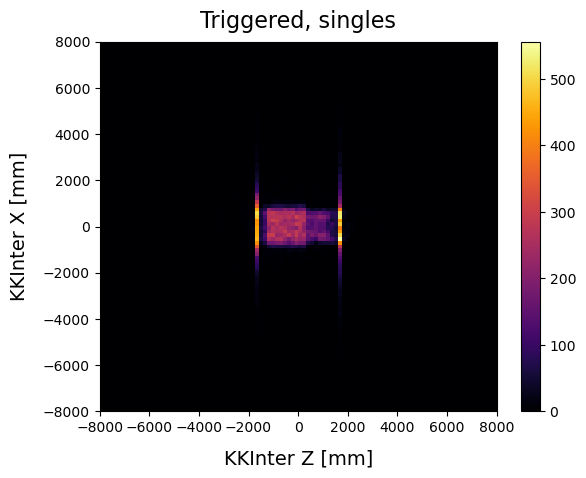


---> Written:
	 ../Images/MDC2020ae/TrackCuts/h2_ZX_triggered_singles.png


<Figure size 640x480 with 0 Axes>

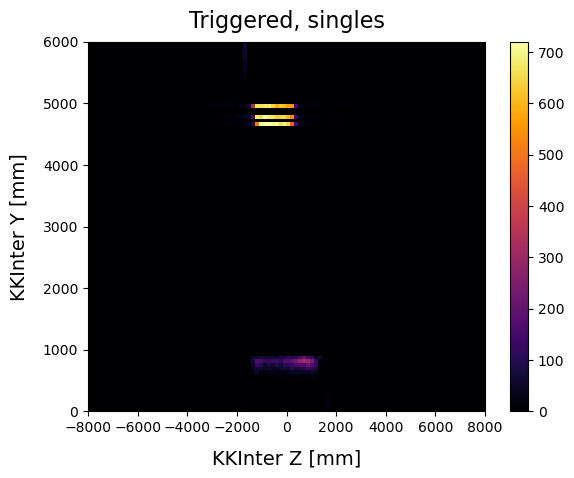


---> Written:
	 ../Images/MDC2020ae/TrackCuts/h2_ZY_triggered_singles.png


<Figure size 640x480 with 0 Axes>

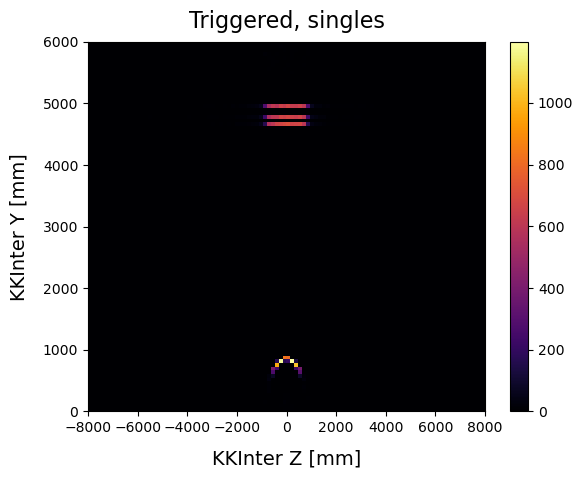


---> Written:
	 ../Images/MDC2020ae/TrackCuts/h2_XY_triggered_singles.png


<Figure size 640x480 with 0 Axes>

In [23]:
'''
Triggered singles
'''

triggered_singles_ = ak.copy(data_)
triggered_singles_ = Trigger(triggered_singles_)
triggered_singles_ = FilterSingles(triggered_singles_)

ut.PrintNEvents(triggered_singles_, 1)

Plot2D(x=ak.flatten(triggered_singles_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fZ"], axis=None)#[:1000]
       , y=ak.flatten(triggered_singles_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fX"], axis=None)#[:1000]
       , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=-8000, ymax=8000
       # , xbox_= [-crvDS_len/2, crvDS_len/2], ybox_ =  [-crvDS_wid/2, crvDS_wid/2]
       , title="Triggered, singles", xlabel="KKInter Z [mm]", ylabel="KKInter X [mm]"
       , fout=f"../Images/{recon}/TrackCuts/h2_ZX_triggered_singles.png")

Plot2D(x=ak.flatten(triggered_singles_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fZ"], axis=None)#[:1000]
       , y=ak.flatten(triggered_singles_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fY"], axis=None)#[:1000]
       , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=0, ymax=6000
       # , xbox_= [-crvDS_len/2, crvDS_len/2], ybox_ =  [-crvDS_wid/2, crvDS_wid/2]
       , title="Triggered, singles", xlabel="KKInter Z [mm]", ylabel="KKInter Y [mm]"
       , fout=f"../Images/{recon}/TrackCuts/h2_ZY_triggered_singles.png")

Plot2D(x=ak.flatten(triggered_singles_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fX"], axis=None)#[:1000]
       , y=ak.flatten(triggered_singles_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fY"], axis=None)#[:1000]
       , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=0, ymax=6000
       # , xbox_= [-crvDS_len/2, crvDS_len/2], ybox_ =  [-crvDS_wid/2, crvDS_wid/2]
       , title="Triggered, singles", xlabel="KKInter Z [mm]", ylabel="KKInter Y [mm]"
       , fout=f"../Images/{recon}/TrackCuts/h2_XY_triggered_singles.png")


---> Triggering
Done!

---> Filtering singles
Done!

---> Applying tracker cuts
-------------------------------------------------------------------------------------
***** evt *****
evtinfo.run: 1205
evtinfo.subrun: 6
evtinfo.event: 101012
***** crv *****
crvcoincs.sectorType: [1, 2, 3]
crvcoincs.nLayers [4, 4, 3]
crvcoincs.angle: [-0.166, 0, -0.529]
crvcoincs.pos.fCoordinates: ([123, -27.1, 296], [4.77e+03, 4.63e+03, 4.91e+03], [315, -437, 286])
crvcoincs.timeStart: [6.13e+04, 6.13e+04, 6.13e+04]
crvcoincs.time: [6.12e+04, 6.13e+04, 6.12e+04]
crvcoincs.PEs: [556, 462, 409]
crvcoincs.PEsPerLayer[4]: [[148, 144, 126, 138], [97.6, 112, 98.4, 154], [118, 151, 140, 0]]
crvcoincs.nHits: [16, 8, 12]
crvcoincsmc.pdgId: [13, 13, 13]
crvcoincsmc.valid: [True, True, True]
crvcoincsmc.primaryE: [1.99e+03, 1.99e+03, 1.99e+03]
***** trk *****
kl.status: [1]
kl.nactive: [21]
kl.nhits: [21]
kl.nplanes: [4]
kl.nnullambig: [1]
kl.ndof: [37]
kl.kl.fitcon: [0.231]
***** trkfit *****
klfit: [[]]
klfit.si

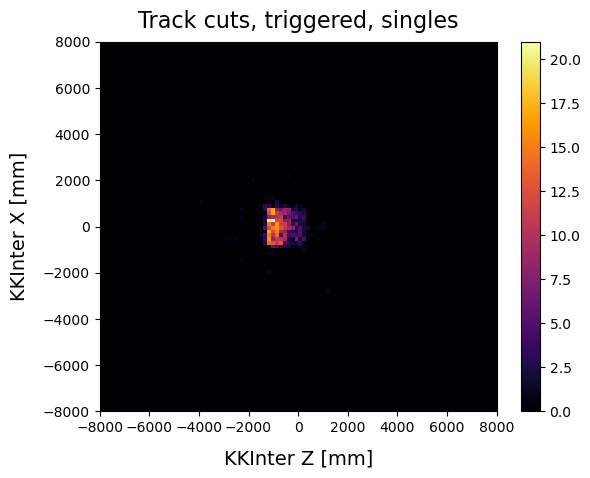


---> Written:
	 ../Images/MDC2020ae/TrackCuts/h2_ZX_track_cuts_triggered_singles.png


<Figure size 640x480 with 0 Axes>

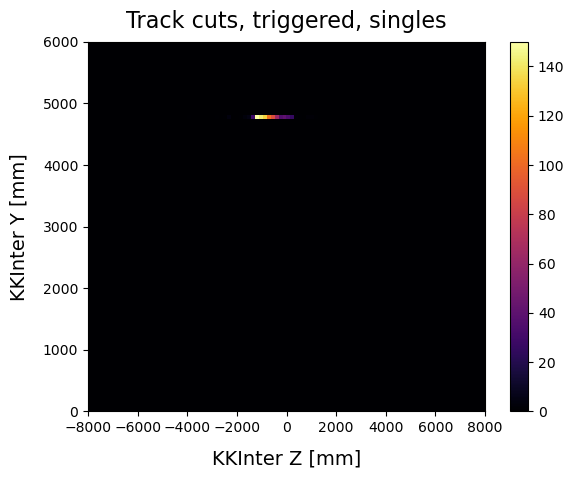


---> Written:
	 ../Images/MDC2020ae/TrackCuts/h2_ZY_track_cuts_triggered_singles.png


<Figure size 640x480 with 0 Axes>

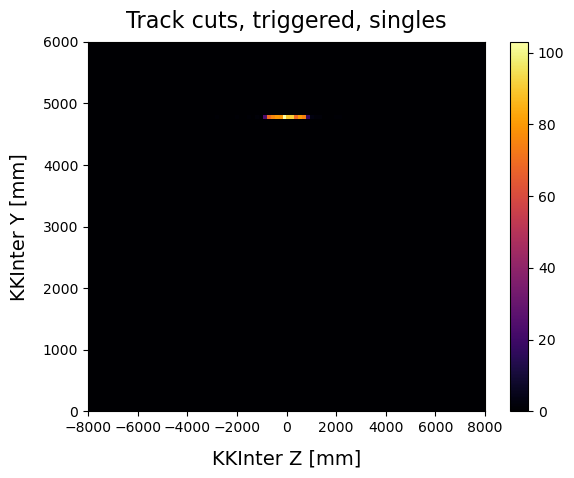


---> Written:
	 ../Images/MDC2020ae/TrackCuts/h2_XY_track_cuts_triggered_singles.png


<Figure size 640x480 with 0 Axes>

In [24]:
'''
Triggered singles with track cuts
'''

track_cuts_triggered_singles_ = ak.copy(data_)
track_cuts_triggered_singles_ = Trigger(track_cuts_triggered_singles_)
track_cuts_triggered_singles_ = FilterSingles(track_cuts_triggered_singles_)
track_cuts_triggered_singles_ = ApplyTrackerCuts(track_cuts_triggered_singles_)

ut.PrintNEvents(track_cuts_triggered_singles_, 1)

Plot2D(x=ak.flatten(track_cuts_triggered_singles_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fZ"], axis=None)#[:1000]
       , y=ak.flatten(track_cuts_triggered_singles_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fX"], axis=None)#[:1000]
       , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=-8000, ymax=8000
       # , xbox_= [-crvDS_len/2, crvDS_len/2], ybox_ =  [-crvDS_wid/2, crvDS_wid/2]
       , title="Track cuts, triggered, singles", xlabel="KKInter Z [mm]", ylabel="KKInter X [mm]"
       , fout=f"../Images/{recon}/TrackCuts/h2_ZX_track_cuts_triggered_singles.png")

Plot2D(x=ak.flatten(track_cuts_triggered_singles_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fZ"], axis=None)#[:1000]
       , y=ak.flatten(track_cuts_triggered_singles_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fY"], axis=None)#[:1000]
       , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=0, ymax=6000
       # , xbox_= [-crvDS_len/2, crvDS_len/2], ybox_ =  [-crvDS_wid/2, crvDS_wid/2]
       , title="Track cuts, triggered, singles", xlabel="KKInter Z [mm]", ylabel="KKInter Y [mm]"
       , fout=f"../Images/{recon}/TrackCuts/h2_ZY_track_cuts_triggered_singles.png")

Plot2D(x=ak.flatten(track_cuts_triggered_singles_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fX"], axis=None)#[:1000]
       , y=ak.flatten(track_cuts_triggered_singles_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fY"], axis=None)#[:1000]
       , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=0, ymax=6000
       # , xbox_= [-crvDS_len/2, crvDS_len/2], ybox_ =  [-crvDS_wid/2, crvDS_wid/2]
       , title="Track cuts, triggered, singles", xlabel="KKInter Z [mm]", ylabel="KKInter Y [mm]"
       , fout=f"../Images/{recon}/TrackCuts/h2_XY_track_cuts_triggered_singles.png")


---> Filtering singles
Done!
-------------------------------------------------------------------------------------
***** evt *****
evtinfo.run: 1205
evtinfo.subrun: 6
evtinfo.eventid: 229
***** crv *****
crvcoincs.sectorType: []
crvcoincs.nLayers []
crvcoincs.angle: []
crvcoincs.pos.fCoordinates: ([], [], [])
crvcoincs.timeStart: []
crvcoincs.time: []
crvcoincs.PEs: []
crvcoincs.PEsPerLayer[4]: []
crvcoincs.nHits: []
crvcoincsmc.pdgId: []
crvcoincsmc.valid: []
crvcoincsmc.primaryE: []
***** trk *****
kl.status: [1]
kl.nactive: [20]
kl.nhits: [20]
kl.nplanes: [8]
kl.nnullambig: [2]
kl.ndof: [35]
kl.kl.fitcon: [0.196]
***** trkfit *****
klfit: [[{mom: {fCoordinates: {...}}, pos: {...}, time: 4.19e+04, ...}, ..., {...}]]
klfit.sid: [[0, 2, 4, 4, 4, 200, 200, 200]]
klfit.sindex: [[0, 0, 0, 0, 0, 0, 1, 2]]
klfit.time: [[4.19e+04, 4.18e+04, 4.18e+04, 4.18e+04, ..., 4.18e+04, 4.18e+04, 4.18e+04]]
klkl: [[{d0: -539, phi0: -1.62, z0: 520, theta: 2.28, mom: 2e+03, t0: ..., ...}, ...]]
klkl.z0er

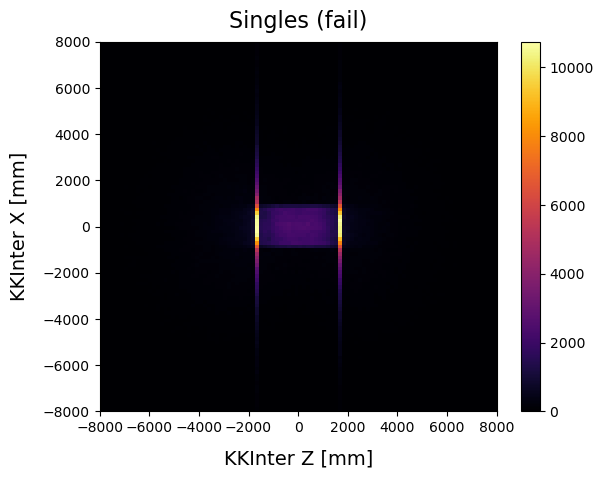


---> Written:
	 ../Images/MDC2020ae/TrackCuts/h2_ZX_singles_fail.png


<Figure size 640x480 with 0 Axes>

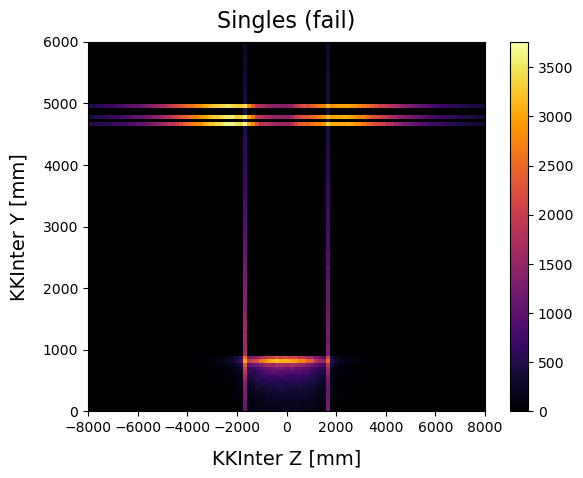


---> Written:
	 ../Images/MDC2020ae/TrackCuts/h2_ZY_singles_fail.png


<Figure size 640x480 with 0 Axes>

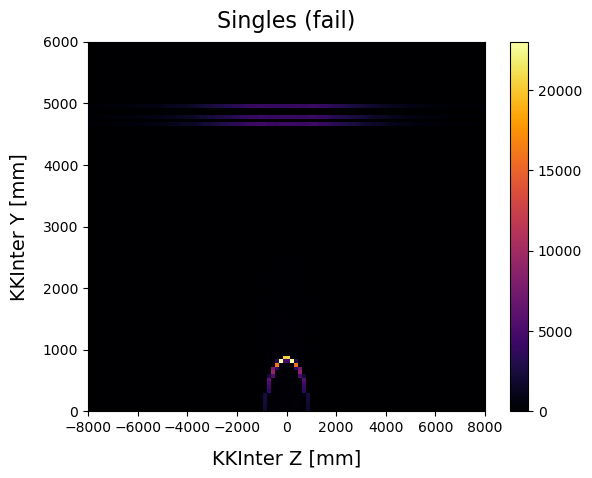


---> Written:
	 ../Images/MDC2020ae/TrackCuts/h2_XY_singles_fail.png


<Figure size 640x480 with 0 Axes>

In [45]:
'''
Fail singles
'''
singles_fail_ = ak.copy(data_)
singles_fail_ = FilterSingles(singles_fail_, fail=True)

def PrintNEvents(data_, nEvents=10, masks_=[]):
     # Iterate event-by-event
    for i, event in enumerate(data_, start=1):
        maskStr=""
        for mask in masks_: 
            maskStr += f"{mask}: {event[f'{mask}']}\n"
        print(pr.PrintEvent(event, maskStr))
        if i >= nEvents: 
            return

PrintNEvents(singles_fail_, 1, masks_=["pass_singles"])
        # eventStr += f"pass_singles: {event['pass_singles']}\n")

Plot2D(x=ak.flatten(singles_fail_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fZ"], axis=None)
       , y=ak.flatten(singles_fail_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fX"], axis=None)
       , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=-8000, ymax=8000
       , title="Singles (fail)", xlabel="KKInter Z [mm]", ylabel="KKInter X [mm]"
       , fout=f"../Images/{recon}/TrackCuts/h2_ZX_singles_fail.png")

Plot2D(x=ak.flatten(singles_fail_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fZ"], axis=None)
       , y=ak.flatten(singles_fail_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fY"], axis=None)
       , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=0, ymax=6000
       , title="Singles (fail)", xlabel="KKInter Z [mm]", ylabel="KKInter Y [mm]"
       , fout=f"../Images/{recon}/TrackCuts/h2_ZY_singles_fail.png")

Plot2D(x=ak.flatten(singles_fail_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fX"], axis=None)
       , y=ak.flatten(singles_fail_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fY"], axis=None)
       , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=0, ymax=6000
       , title="Singles (fail)", xlabel="KKInter Z [mm]", ylabel="KKInter Y [mm]"
       , fout=f"../Images/{recon}/TrackCuts/h2_XY_singles_fail.png")

In [46]:
pr.PrintNEvents(data_[(data_["evt"]["evtinfo.run"] == 1205) & (data_["evt"]["evtinfo.subrun"] == 6) & (data_["evt"]["evtinfo.event"] == 229)])

-------------------------------------------------------------------------------------
***** evt *****
evtinfo.run: 1205
evtinfo.subrun: 6
evtinfo.eventid: 229
***** crv *****
crvcoincs.sectorType: []
crvcoincs.nLayers []
crvcoincs.angle: []
crvcoincs.pos.fCoordinates: ([], [], [])
crvcoincs.timeStart: []
crvcoincs.time: []
crvcoincs.PEs: []
crvcoincs.PEsPerLayer[4]: []
crvcoincs.nHits: []
crvcoincsmc.pdgId: []
crvcoincsmc.valid: []
crvcoincsmc.primaryE: []
***** trk *****
kl.status: [1]
kl.nactive: [20]
kl.nhits: [20]
kl.nplanes: [8]
kl.nnullambig: [2]
kl.ndof: [35]
kl.kl.fitcon: [0.196]
***** trkfit *****
klfit: [[{mom: {fCoordinates: {...}}, pos: {...}, time: 4.19e+04, ...}, ..., {...}]]
klfit.sid: [[0, 2, 4, 4, 4, 200, 200, 200]]
klfit.sindex: [[0, 0, 0, 0, 0, 0, 1, 2]]
klfit.time: [[4.19e+04, 4.18e+04, 4.18e+04, 4.18e+04, ..., 4.18e+04, 4.18e+04, 4.18e+04]]
klkl: [[{d0: -539, phi0: -1.62, z0: 520, theta: 2.28, mom: 2e+03, t0: ..., ...}, ...]]
klkl.z0err: [[0.218, 0.238, 0.238, 0.21


---> Filtering singles
Done!

---> Applying tracker cuts
-------------------------------------------------------------------------------------
***** evt *****
evtinfo.run: 1205
evtinfo.subrun: 6
evtinfo.eventid: 6837
***** crv *****
crvcoincs.sectorType: [1, 2, 3]
crvcoincs.nLayers [4, 4, 2]
crvcoincs.angle: [-0.345, -1.99e-12, 0.32]
crvcoincs.pos.fCoordinates: ([472, 78.5, 642], [4.77e+03, 4.62e+03, 4.95e+03], [-1.3e+03, -437, -1.32e+03])
crvcoincs.timeStart: [6.7e+04, 6.7e+04, 6.7e+04]
crvcoincs.time: [6.7e+04, 6.7e+04, 6.7e+04]
crvcoincs.PEs: [516, 462, 256]
crvcoincs.PEsPerLayer[4]: [[144, 111, 141, 121], [127, 105, 106, 125], [0, 0, 149, 106]]
crvcoincs.nHits: [16, 8, 8]
crvcoincsmc.pdgId: [-13, -13, -13]
crvcoincsmc.valid: [True, True, True]
crvcoincsmc.primaryE: [3.7e+04, 3.7e+04, 3.7e+04]
***** trk *****
kl.status: [1]
kl.nactive: [15]
kl.nhits: [15]
kl.nplanes: [2]
kl.nnullambig: [3]
kl.ndof: [25]
kl.kl.fitcon: [0.87]
***** trkfit *****
klfit: [[{mom: {fCoordinates: {...}}, p

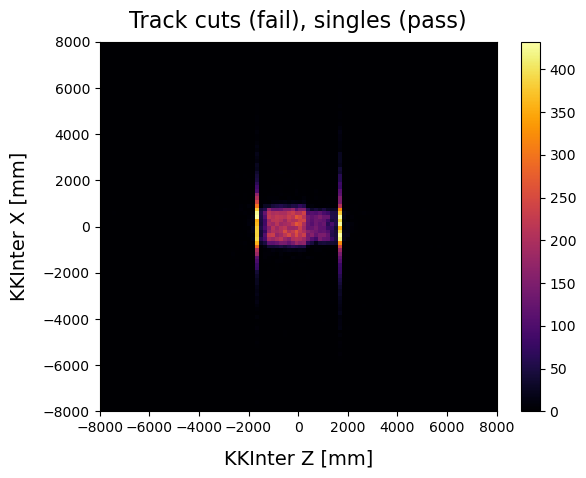


---> Written:
	 ../Images/MDC2020ae/TrackCuts/h2_ZX_fail_track_cuts_pass_singles_.png


<Figure size 640x480 with 0 Axes>

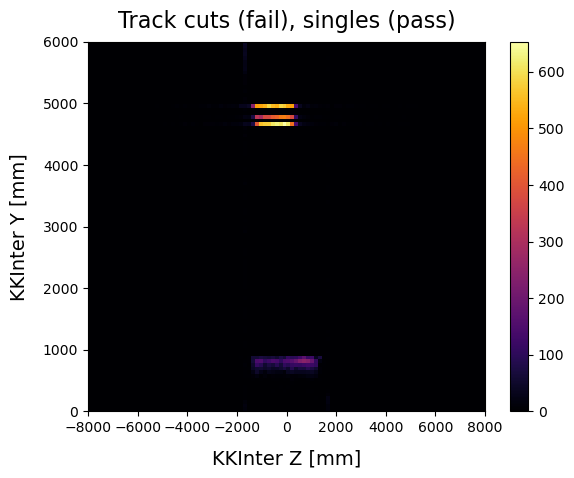


---> Written:
	 ../Images/MDC2020ae/TrackCuts/h2_ZY_fail_track_cuts_pass_singles_.png


<Figure size 640x480 with 0 Axes>

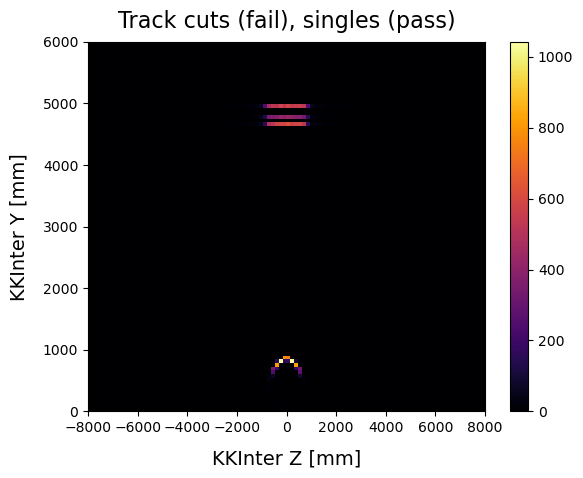


---> Written:
	 ../Images/MDC2020ae/TrackCuts/h2_XY_fail_track_cuts_pass_singles_.png


<Figure size 640x480 with 0 Axes>

In [78]:
'''
Pass singles, fail track
'''

fail_track_cuts_pass_singles_ = ak.copy(data_)
fail_track_cuts_pass_singles_ = FilterSingles(fail_track_cuts_pass_singles_, fail=False)
fail_track_cuts_pass_singles_ = ApplyTrackerCuts(fail_track_cuts_pass_singles_, fail=True)

PrintNEvents(fail_track_cuts_pass_singles_, 1, ["pass_singles", "fail_track_cuts", "trk_bestFit", "trkfit_bestFit"]) # track_cuts"])

print(len(ak.flatten(fail_track_cuts_pass_singles_["evt"]["evtinfo.event"], axis=None)))

Plot2D(x=ak.flatten(fail_track_cuts_pass_singles_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fZ"], axis=None)#[:1000]
       , y=ak.flatten(fail_track_cuts_pass_singles_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fX"], axis=None)#[:1000]
       , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=-8000, ymax=8000
       # , xbox_= [-crvDS_len/2, crvDS_len/2], ybox_ =  [-crvDS_wid/2, crvDS_wid/2]
       , title="Track cuts (fail), singles (pass)", xlabel="KKInter Z [mm]", ylabel="KKInter X [mm]"
       , fout=f"../Images/{recon}/TrackCuts/h2_ZX_fail_track_cuts_pass_singles_.png")

Plot2D(x=ak.flatten(fail_track_cuts_pass_singles_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fZ"], axis=None)#[:1000]
       , y=ak.flatten(fail_track_cuts_pass_singles_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fY"], axis=None)#[:1000]
       , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=0, ymax=6000
       # , xbox_= [-crvDS_len/2, crvDS_len/2], ybox_ =  [-crvDS_wid/2, crvDS_wid/2]
       , title="Track cuts (fail), singles (pass)", xlabel="KKInter Z [mm]", ylabel="KKInter Y [mm]"
       , fout=f"../Images/{recon}/TrackCuts/h2_ZY_fail_track_cuts_pass_singles_.png")

Plot2D(x=ak.flatten(fail_track_cuts_pass_singles_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fX"], axis=None)#[:1000]
       , y=ak.flatten(fail_track_cuts_pass_singles_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fY"], axis=None)#[:1000]
       , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=0, ymax=6000
       # , xbox_= [-crvDS_len/2, crvDS_len/2], ybox_ =  [-crvDS_wid/2, crvDS_wid/2]
       , title="Track cuts (fail), singles (pass)", xlabel="KKInter Z [mm]", ylabel="KKInter Y [mm]"
       , fout=f"../Images/{recon}/TrackCuts/h2_XY_fail_track_cuts_pass_singles_.png")


---> Triggering
Done!

---> Filtering singles
Done!

---> Applying tracker cuts
-------------------------------------------------------------------------------------
***** evt *****
evtinfo.run: 1205
evtinfo.subrun: 6
evtinfo.eventid: 6837
***** crv *****
crvcoincs.sectorType: [1, 2, 3]
crvcoincs.nLayers [4, 4, 2]
crvcoincs.angle: [-0.345, -1.99e-12, 0.32]
crvcoincs.pos.fCoordinates: ([472, 78.5, 642], [4.77e+03, 4.62e+03, 4.95e+03], [-1.3e+03, -437, -1.32e+03])
crvcoincs.timeStart: [6.7e+04, 6.7e+04, 6.7e+04]
crvcoincs.time: [6.7e+04, 6.7e+04, 6.7e+04]
crvcoincs.PEs: [516, 462, 256]
crvcoincs.PEsPerLayer[4]: [[144, 111, 141, 121], [127, 105, 106, 125], [0, 0, 149, 106]]
crvcoincs.nHits: [16, 8, 8]
crvcoincsmc.pdgId: [-13, -13, -13]
crvcoincsmc.valid: [True, True, True]
crvcoincsmc.primaryE: [3.7e+04, 3.7e+04, 3.7e+04]
***** trk *****
kl.status: [1]
kl.nactive: [15]
kl.nhits: [15]
kl.nplanes: [2]
kl.nnullambig: [3]
kl.ndof: [25]
kl.kl.fitcon: [0.87]
***** trkfit *****
klfit: [[{mom: {

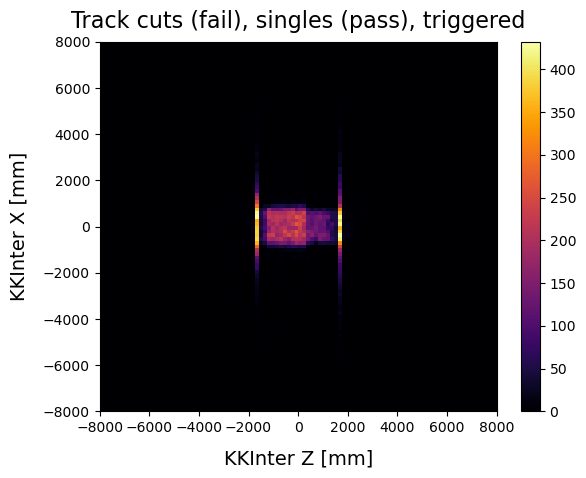


---> Written:
	 ../Images/MDC2020ae/TrackCuts/h2_ZX_triggered_fail_track_cuts_pass_singles.png


<Figure size 640x480 with 0 Axes>

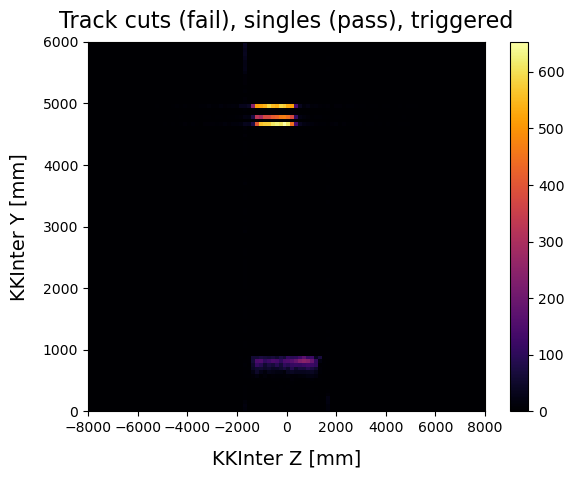


---> Written:
	 ../Images/MDC2020ae/TrackCuts/h2_ZY_triggered_fail_track_cuts_pass_singles.png


<Figure size 640x480 with 0 Axes>

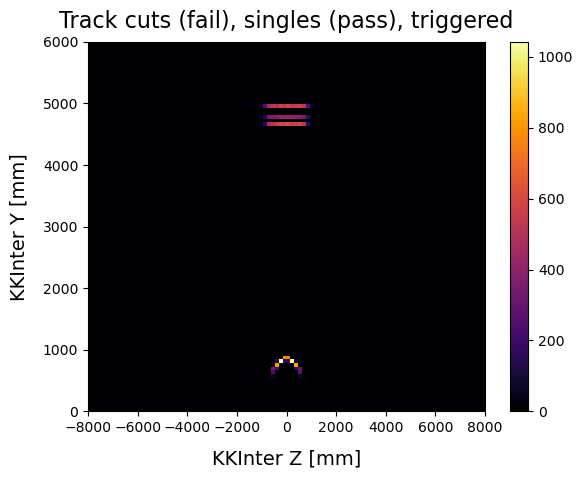


---> Written:
	 ../Images/MDC2020ae/TrackCuts/h2_XY_triggered_fail_track_cuts_pass_singles.png


<Figure size 640x480 with 0 Axes>

In [87]:
'''
Pass singles, fail track, triggered
'''

triggered_fail_track_cuts_pass_singles_ = ak.copy(data_)
triggered_fail_track_cuts_pass_singles_ = Trigger(triggered_fail_track_cuts_pass_singles_)
triggered_fail_track_cuts_pass_singles_ = FilterSingles(triggered_fail_track_cuts_pass_singles_, fail=False)
triggered_fail_track_cuts_pass_singles_ = ApplyTrackerCuts(triggered_fail_track_cuts_pass_singles_, fail=True)

PrintNEvents(triggered_fail_track_cuts_pass_singles_, 1, ["pass_trigger", "pass_singles", "fail_track_cuts", "trk_bestFit", "trkfit_bestFit", "trkfit_KLCRV1"]) # track_cuts"])

print(len(ak.flatten(triggered_fail_track_cuts_pass_singles_["evt"]["evtinfo.event"], axis=None)))

Plot2D(x=ak.flatten(triggered_fail_track_cuts_pass_singles_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fZ"], axis=None)#[:1000]
       , y=ak.flatten(triggered_fail_track_cuts_pass_singles_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fX"], axis=None)#[:1000]
       , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=-8000, ymax=8000
       # , xbox_= [-crvDS_len/2, crvDS_len/2], ybox_ =  [-crvDS_wid/2, crvDS_wid/2]
       , title="Track cuts (fail), singles (pass), triggered", xlabel="KKInter Z [mm]", ylabel="KKInter X [mm]"
       , fout=f"../Images/{recon}/TrackCuts/h2_ZX_triggered_fail_track_cuts_pass_singles.png")

Plot2D(x=ak.flatten(triggered_fail_track_cuts_pass_singles_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fZ"], axis=None)#[:1000]
       , y=ak.flatten(triggered_fail_track_cuts_pass_singles_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fY"], axis=None)#[:1000]
       , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=0, ymax=6000
       # , xbox_= [-crvDS_len/2, crvDS_len/2], ybox_ =  [-crvDS_wid/2, crvDS_wid/2]
       , title="Track cuts (fail), singles (pass), triggered", xlabel="KKInter Z [mm]", ylabel="KKInter Y [mm]"
       , fout=f"../Images/{recon}/TrackCuts/h2_ZY_triggered_fail_track_cuts_pass_singles.png")

Plot2D(x=ak.flatten(triggered_fail_track_cuts_pass_singles_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fX"], axis=None)#[:1000]
       , y=ak.flatten(triggered_fail_track_cuts_pass_singles_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fY"], axis=None)#[:1000]
       , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=0, ymax=6000
       # , xbox_= [-crvDS_len/2, crvDS_len/2], ybox_ =  [-crvDS_wid/2, crvDS_wid/2]
       , title="Track cuts (fail), singles (pass), triggered", xlabel="KKInter Z [mm]", ylabel="KKInter Y [mm]"
       , fout=f"../Images/{recon}/TrackCuts/h2_XY_triggered_fail_track_cuts_pass_singles.png")

In [109]:
'''

Loosen the cuts. 

I just want any fit that intersects with CRV-T. 

'''

def ApplyLooseTrackerCuts(arrays_, fail=False, quiet=False):
    
    if not quiet: print(f"\n---> Applying tracker cuts") 

    # Mark cuts on the track and track fit level
    arrays_["trkfit_KLCRV1"] = ( 
        (arrays_["trkfit"]["klfit"]["sid"] == 200) 
        & (arrays_["trkfit"]["klfit"]["sindex"] == 1) )

    # arrays_["trk_bestFit"] = ( 
    #     (arrays_["trk"]["kl.ndof"] >= 10)
    #     & (arrays_["trk"]["kl.fitcon"] > 0.1)
    #     & ((arrays_["trk"]["kl.nactive"]/arrays_["trk"]["kl.nhits"]) > 0.99)
    #     & (arrays_["trk"]["kl.nplanes"] >= 4)
    #     & ((arrays_["trk"]["kl.nnullambig"]/arrays_["trk"]["kl.nhits"]) < 0.2) )
    
    # arrays_["trkfit_bestFit"] = ( 
    #     (arrays_["trkfit"]["klkl"]["z0err"] < 1) 
    #     & (arrays_["trkfit"]["klkl"]["d0err"] < 1) 
    #     & (arrays_["trkfit"]["klkl"]["thetaerr"] < 0.004)
    #     & (arrays_["trkfit"]["klkl"]["phi0err"] < 0.001) )


    # This is just so you can plot the intersection point.
    if not fail: 
        # Create masks
        arrays_["trkfit"] = arrays_["trkfit"][arrays_["trkfit_KLCRV1"]]
    else: 
        # Create masks
        arrays_["trkfit"] = arrays_["trkfit"][~arrays_["trkfit_KLCRV1"]]


# trkCut = ak.any(arrays_["trk"]["kl.status"], axis=1, keepdims=False) > 0 
#     # Check for a track fit in the event after cuts
#     trkFitCut = (
#         (ak.count(arrays_["trkfit"]["klfit"]["sid"], axis=-1, keepdims=False) > 0) 
#         & (ak.count(arrays_["trkfit"]["klkl"]["z0err"], axis=-1, keepdims=False) > 0) )


    # Event level cases where we do not intersect with the CRV-T
    arrays_["pass_track_cuts"] = ak.any(arrays_["trkfit_KLCRV1"], axis=-1, keepdims=False) == True
    # Reset to event level. 
    arrays_["pass_track_cuts"] = ak.any( arrays_["pass_track_cuts"], axis=-1, keepdims=False) == True
    
    print(arrays_["pass_track_cuts"])

    # Both do the same thing, but mark them pass/fail for bookkeeping.
    if not fail: 
        return arrays_[arrays_["pass_track_cuts"]]
    else: 
        return arrays_[~arrays_["pass_track_cuts"]]


---> Triggering
Done!

---> Filtering singles
Done!

---> Applying tracker cuts
[True, True, True, True, True, True, ..., True, True, True, True, True, True]
-------------------------------------------------------------------------------------
***** evt *****
evtinfo.run: 1205
evtinfo.subrun: 1216
evtinfo.eventid: 497419
***** crv *****
crvcoincs.sectorType: [1, 2, 3]
crvcoincs.nLayers [4, 4, 4]
crvcoincs.angle: [-0.732, -4.23e-12, -0.376]
crvcoincs.pos.fCoordinates: ([-394, -182, -297], [4.77e+03, 4.62e+03, 4.92e+03], [-705, -437, -784])
crvcoincs.timeStart: [6.71e+04, 6.71e+04, 6.71e+04]
crvcoincs.time: [6.71e+04, 6.71e+04, 6.71e+04]
crvcoincs.PEs: [568, 472, 530]
crvcoincs.PEsPerLayer[4]: [[164, 125, 147, 132], [115, 133, 113, 112], [133, 148, 116, 132]]
crvcoincs.nHits: [17, 8, 16]
crvcoincsmc.pdgId: [-13, -13, -13]
crvcoincsmc.valid: [True, True, True]
crvcoincsmc.primaryE: [1.86e+03, 1.86e+03, 1.86e+03]
***** trk *****
kl.status: [1]
kl.nactive: [21]
kl.nhits: [32]
kl.nplanes: [

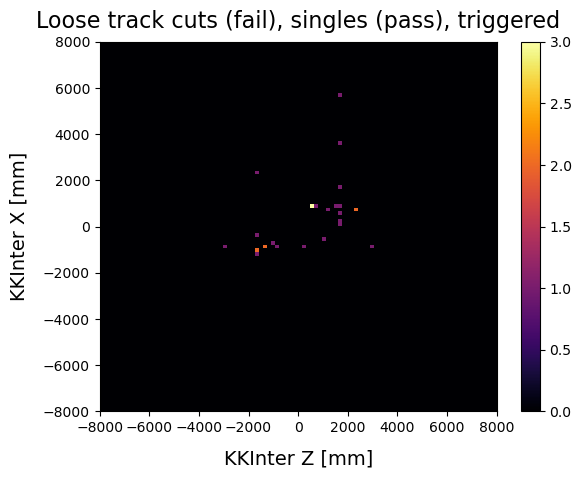


---> Written:
	 ../Images/MDC2020ae/TrackCuts/h2_ZX_triggered_fail_track_cuts_pass_singles_loose.png


<Figure size 640x480 with 0 Axes>

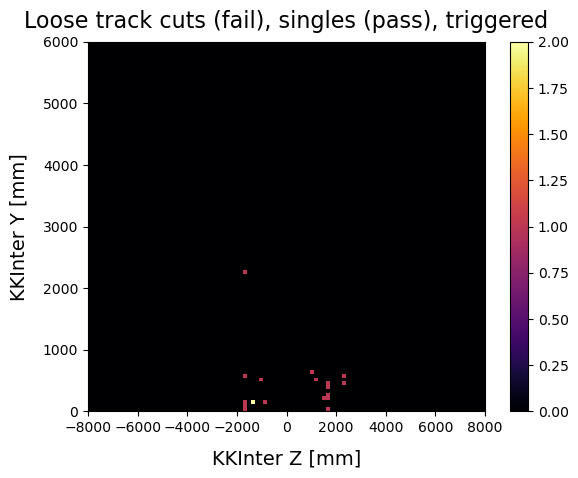


---> Written:
	 ../Images/MDC2020ae/TrackCuts/h2_ZY_triggered_fail_track_cuts_pass_singles_loose.png


<Figure size 640x480 with 0 Axes>

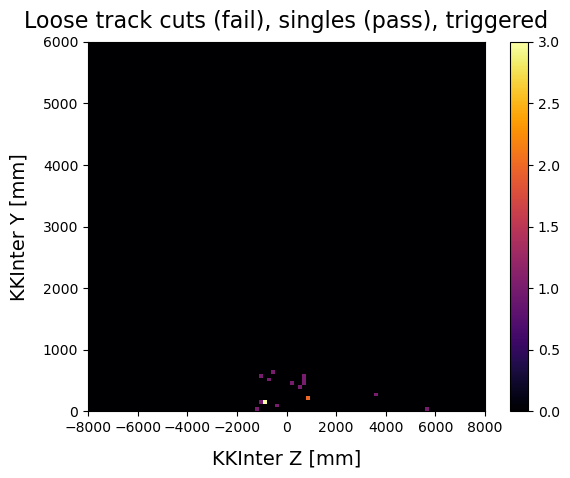


---> Written:
	 ../Images/MDC2020ae/TrackCuts/h2_XY_triggered_fail_track_cuts_pass_singles_loose.png


<Figure size 640x480 with 0 Axes>

In [110]:
'''
Pass singles, fail track, triggered

LOOSE CUTS

'''

triggered_fail_track_cuts_pass_singles_ = ak.copy(data_)
triggered_fail_track_cuts_pass_singles_ = Trigger(triggered_fail_track_cuts_pass_singles_)
triggered_fail_track_cuts_pass_singles_ = FilterSingles(triggered_fail_track_cuts_pass_singles_, fail=False)
triggered_fail_track_cuts_pass_singles_ = ApplyLooseTrackerCuts(triggered_fail_track_cuts_pass_singles_, fail=True)

PrintNEvents(triggered_fail_track_cuts_pass_singles_, 1, ["pass_trigger", "pass_singles", "pass_track_cuts", "trkfit_KLCRV1"]) 

print(len(ak.flatten(triggered_fail_track_cuts_pass_singles_["evt"]["evtinfo.event"], axis=None)))

Plot2D(x=ak.flatten(triggered_fail_track_cuts_pass_singles_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fZ"], axis=None)#[:1000]
       , y=ak.flatten(triggered_fail_track_cuts_pass_singles_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fX"], axis=None)#[:1000]
       , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=-8000, ymax=8000
       # , xbox_= [-crvDS_len/2, crvDS_len/2], ybox_ =  [-crvDS_wid/2, crvDS_wid/2]
       , title="Loose track cuts (fail), singles (pass), triggered", xlabel="KKInter Z [mm]", ylabel="KKInter X [mm]"
       , fout=f"../Images/{recon}/TrackCuts/h2_ZX_triggered_fail_track_cuts_pass_singles_loose.png")

Plot2D(x=ak.flatten(triggered_fail_track_cuts_pass_singles_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fZ"], axis=None)#[:1000]
       , y=ak.flatten(triggered_fail_track_cuts_pass_singles_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fY"], axis=None)#[:1000]
       , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=0, ymax=6000
       # , xbox_= [-crvDS_len/2, crvDS_len/2], ybox_ =  [-crvDS_wid/2, crvDS_wid/2]
       , title="Loose track cuts (fail), singles (pass), triggered", xlabel="KKInter Z [mm]", ylabel="KKInter Y [mm]"
       , fout=f"../Images/{recon}/TrackCuts/h2_ZY_triggered_fail_track_cuts_pass_singles_loose.png")

Plot2D(x=ak.flatten(triggered_fail_track_cuts_pass_singles_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fX"], axis=None)#[:1000]
       , y=ak.flatten(triggered_fail_track_cuts_pass_singles_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fY"], axis=None)#[:1000]
       , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=0, ymax=6000
       # , xbox_= [-crvDS_len/2, crvDS_len/2], ybox_ =  [-crvDS_wid/2, crvDS_wid/2]
       , title="Loose track cuts (fail), singles (pass), triggered", xlabel="KKInter Z [mm]", ylabel="KKInter Y [mm]"
       , fout=f"../Images/{recon}/TrackCuts/h2_XY_triggered_fail_track_cuts_pass_singles_loose.png")


---> Triggering
Done!

---> Filtering singles
Done!

---> Applying tracker cuts
-------------------------------------------------------------------------------------
***** evt *****
evtinfo.run: 1205
evtinfo.subrun: 6
evtinfo.eventid: 6837
***** crv *****
crvcoincs.sectorType: [1, 2, 3]
crvcoincs.nLayers [4, 4, 2]
crvcoincs.angle: [-0.345, -1.99e-12, 0.32]
crvcoincs.pos.fCoordinates: ([472, 78.5, 642], [4.77e+03, 4.62e+03, 4.95e+03], [-1.3e+03, -437, -1.32e+03])
crvcoincs.timeStart: [6.7e+04, 6.7e+04, 6.7e+04]
crvcoincs.time: [6.7e+04, 6.7e+04, 6.7e+04]
crvcoincs.PEs: [516, 462, 256]
crvcoincs.PEsPerLayer[4]: [[144, 111, 141, 121], [127, 105, 106, 125], [0, 0, 149, 106]]
crvcoincs.nHits: [16, 8, 8]
crvcoincsmc.pdgId: [-13, -13, -13]
crvcoincsmc.valid: [True, True, True]
crvcoincsmc.primaryE: [3.7e+04, 3.7e+04, 3.7e+04]
***** trk *****
kl.status: [1]
kl.nactive: [15]
kl.nhits: [15]
kl.nplanes: [2]
kl.nnullambig: [3]
kl.ndof: [25]
kl.kl.fitcon: [0.87]
***** trkfit *****
klfit: [[{mom: {

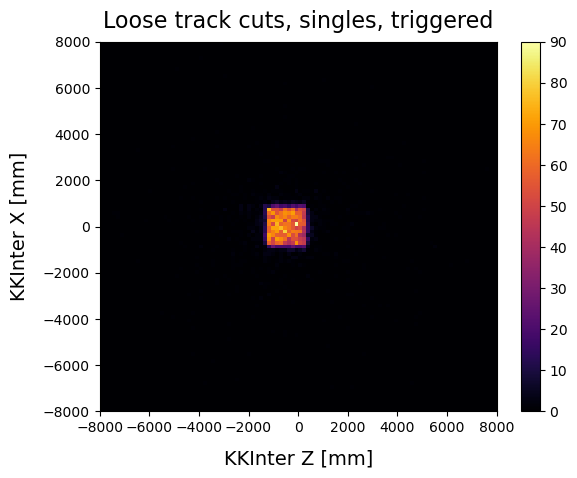


---> Written:
	 ../Images/MDC2020ae/TrackCuts/h2_ZX_triggered_pass_loose_track_cutss_singles_loose.png


<Figure size 640x480 with 0 Axes>

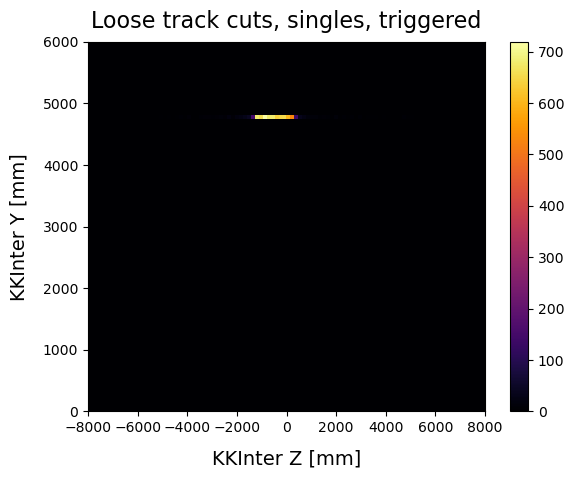


---> Written:
	 ../Images/MDC2020ae/TrackCuts/h2_ZY_triggered_pass_loose_track_cuts_pass_singles_loose.png


<Figure size 640x480 with 0 Axes>

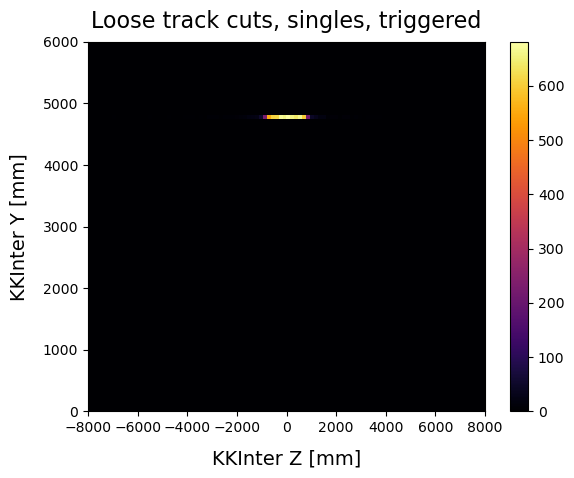


---> Written:
	 ../Images/MDC2020ae/TrackCuts/h2_XY_triggered_pass_loose_track_cuts_pass_singles.png


<Figure size 640x480 with 0 Axes>

In [91]:
'''
Pass singles, pass track, triggered

LOOSE CUTS

'''

triggered_loose_track_cuts_singles_ = ak.copy(data_)
triggered_loose_track_cuts_singles_ = Trigger(triggered_loose_track_cuts_singles_)
triggered_loose_track_cuts_singles_ = FilterSingles(triggered_loose_track_cuts_singles_, fail=False)
triggered_loose_track_cuts_singles_ = ApplyLooseTrackerCuts(triggered_loose_track_cuts_singles_, fail=False)

PrintNEvents(triggered_loose_track_cuts_singles_, 1, ["pass_trigger", "pass_singles", "pass_track_cuts", "trkfit_KLCRV1"]) # track_cuts"])

print(len(ak.flatten(triggered_loose_track_cuts_singles_["evt"]["evtinfo.event"], axis=None)))

Plot2D(x=ak.flatten(triggered_loose_track_cuts_singles_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fZ"], axis=None)#[:1000]
       , y=ak.flatten(triggered_loose_track_cuts_singles_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fX"], axis=None)#[:1000]
       , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=-8000, ymax=8000
       # , xbox_= [-crvDS_len/2, crvDS_len/2], ybox_ =  [-crvDS_wid/2, crvDS_wid/2]
       , title="Loose track cuts, singles, triggered", xlabel="KKInter Z [mm]", ylabel="KKInter X [mm]"
       , fout=f"../Images/{recon}/TrackCuts/h2_ZX_triggered_pass_loose_track_cutss_singles_loose.png")

Plot2D(x=ak.flatten(triggered_loose_track_cuts_singles_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fZ"], axis=None)#[:1000]
       , y=ak.flatten(triggered_loose_track_cuts_singles_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fY"], axis=None)#[:1000]
       , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=0, ymax=6000
       # , xbox_= [-crvDS_len/2, crvDS_len/2], ybox_ =  [-crvDS_wid/2, crvDS_wid/2]
       , title="Loose track cuts, singles, triggered", xlabel="KKInter Z [mm]", ylabel="KKInter Y [mm]"
       , fout=f"../Images/{recon}/TrackCuts/h2_ZY_triggered_pass_loose_track_cuts_pass_singles_loose.png")

Plot2D(x=ak.flatten(triggered_loose_track_cuts_singles_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fX"], axis=None)#[:1000]
       , y=ak.flatten(triggered_loose_track_cuts_singles_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fY"], axis=None)#[:1000]
       , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=0, ymax=6000
       # , xbox_= [-crvDS_len/2, crvDS_len/2], ybox_ =  [-crvDS_wid/2, crvDS_wid/2]
       , title="Loose track cuts, singles, triggered", xlabel="KKInter Z [mm]", ylabel="KKInter Y [mm]"
       , fout=f"../Images/{recon}/TrackCuts/h2_XY_triggered_pass_loose_track_cuts_pass_singles.png")

In [ ]:
# '''
# Track cuts
# '''

# track_cuts_ = ApplyTrackerCuts(data_, fail=False)
 
# Plot2D(x=ak.flatten(track_cuts_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fZ"], axis=None)
#          , y=ak.flatten(track_cuts_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fX"], axis=None)
#          , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=-8000, ymax=8000
#          # , xbox_= [-crvDS_len/2, crvDS_len/2], ybox_ =  [-crvDS_wid/2, crvDS_wid/2]
#          , title="Track cuts only", xlabel="KKInter Z [mm]", ylabel="KKInter X [mm]"
#          , fout=f"../Images/{recon}/TrackCuts/{filters_[1]}/h2_ZX_track_cuts_only.png")

# Plot2D(x=ak.flatten(track_cuts_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fZ"], axis=None)
#          , y=ak.flatten(track_cuts_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fY"], axis=None)
#          , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=3000, ymax=6000
#          # , xbox_= [-crvDS_len/2, crvDS_len/2], ybox_ =  [-crvDS_wid/2, crvDS_wid/2]
#          , title="Track cuts only", xlabel="KKInter Z [mm]", ylabel="KKInter Y [mm]"
#          , fout=f"../Images/{recon}/TrackCuts/{filters_[1]}/h2_ZY_track_cuts_only.png")